# Lead 210 Model

Version 2 of the notebook

Imports

In [89]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
import datetime
custom_params = {"axes.spines.right": False, "axes.spines.bottom": False}
sns.set_theme(style="ticks", rc=custom_params)
import pymc as pm

import arviz as az
pd.set_option('display.colheader_justify', 'center')

data = pd.read_excel('data/lavelle_lead210_clean.xlsx')
cols = data.columns[1:]
for col in cols:
    data[col] = pd.to_numeric(data[col], errors='coerce')


## Plot Data

In [90]:
def plot_core_ax(df, ax, x , y, title = 'Total Lead 210', ylabel = 'Depth (g/cm2)', unit = 'dpm/g', err_plot = False, legend=True):
 
    cores = df.Core.unique()
    if err_plot:
        err =  x+'_Err'
    else:
        err = 0
        
    for core in cores:
        df[df.Core==core].dropna(subset = [x]).plot(x = x, y= y, ax = ax, xerr = err)


    if df[x].min()>0:
        ax.set_xlim(0)
    
    if legend:
        ax.legend([core for core in cores], loc='upper center', bbox_to_anchor=(0.5, -0.05))
    else:
        ax.get_legend().remove()

    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    
    ax.set_ylabel(ylabel)
    ax.set_xlabel(unit)
    ax.set_title(title)
    ax.invert_yaxis()
    

In [91]:
def plot_some_cores(cores):
    fig, axes = plt.subplots(1, len(cores), figsize=(10,4))
    for ax, core in zip(axes, cores):
        plot_core_ax(data[data.Core==core], ax, 'Pb210', 'Median_mass_g_cm2', 
                    title=core, legend=False, err_plot=True)
    plt.tight_layout()
        

In [92]:
def plot_cores(cores, rows, cols, ylim = (250, 0), xlim = (0,15), figsize=(12, 6)):
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    for ax, core in zip(axes.flatten(), cores):
        plot_core_ax(data[data.Core==core], ax, 'Pb210', 'Median_mass_g_cm2', 
                    title=core, legend=False, err_plot=True)
        ax.set_ylim(ylim)
        ax.set_xlim(xlim)
    plt.tight_layout()
        

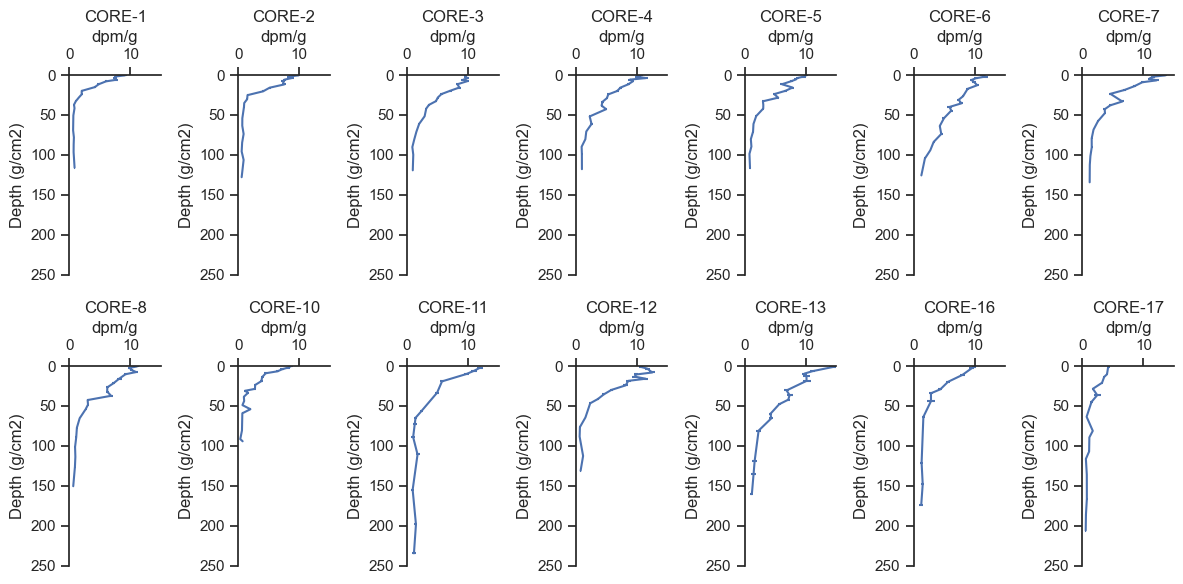

In [93]:
cores = data.Core.unique()
plot_cores(cores, 2, 7)

## Python Model

In [94]:
def A_calc_coeffs(w = 0.1,          # g/cm2/yr
            Phi = 10,               # dpm/cm2/yr
            ma = 5,                 # g/cm2
            km = 0.5,               # g2/cm4/yr
            lam = np.log(2)/22.3):  # yr
             
    xp = (w + (w**2 + 4 * lam * km)**(1/2))/(2 * km)
    xm = (w - (w**2 + 4 * lam * km)**(1/2))/(2 * km)
    eps = xm/xp*np.exp((xm-xp)*ma)
    Gamp = w - km * xp
    Gamm = w - km * xm
    Cm = Phi / (Gamm - eps * Gamp)
    Cp = - eps * Cm
    CII = (np.exp(xm*ma) - eps * np.exp(xp * ma) ) * Cm / np.exp(-lam*ma/w)
    
    return ma, xp, xm, Cm, Cp, CII, lam, w

In [95]:
def A_calc(m, ma, xp, xm, Cm, Cp, CII, lam, w, s):
    if m < ma:
        return Cp  * np.exp(xp * m) + Cm * np.exp(xm * m) + s
    if m >= ma:
        return CII * np.exp(-lam*m/w) + s

vect_A_calc = np.vectorize(A_calc)

In [96]:
def make_model_lines(
                        ylim=(250, 0),  # set up the mass depth array
                        w_prior = 0.2,                       # deposition rate g/cm2/yr
                        Phi_prior = .4,                       # loading rate dpm/cm2/yr
                        ma_prior = 7.5 ,                    # depth of mixing g/cm2
                        km_prior = 10,
                        support_prior = 1):
    mass_depth = np.linspace(ylim[1], ylim[0],200)
    # diffusion coefficient g2/cm4/yr
    ma, xp, xm, Cm, Cp, CII, lam, w  = A_calc_coeffs(w_prior, Phi_prior, ma_prior, km_prior)
    At = vect_A_calc(mass_depth, ma, xp, xm, Cm, Cp, CII, lam, w , support_prior)

    priors = pd.DataFrame()
    priors['mass_depth'] = mass_depth
    priors['At'] = At
    return priors


In [97]:
priors = make_model_lines(Phi_prior=10, ma_prior=10,  w_prior=1)

In [98]:
def plot_cores_w_model(cores, rows, cols, ylim, xlim, figsize, model_line_kwargs, alpha=1):
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    for ax, core in zip(axes.flatten(), cores):
        plot_core_ax(data[data.Core==core], ax, 'Pb210', 'Median_mass_g_cm2', 
                    title=core, legend=False, err_plot=True)
        make_model_lines(**model_line_kwargs).plot(
            ax = ax, x = 'At', y = 'mass_depth', color='black', alpha=alpha)
        ax.set_ylim(ylim)
        ax.set_xlim(xlim)
        ax.get_legend().remove()
    plt.tight_layout()
        

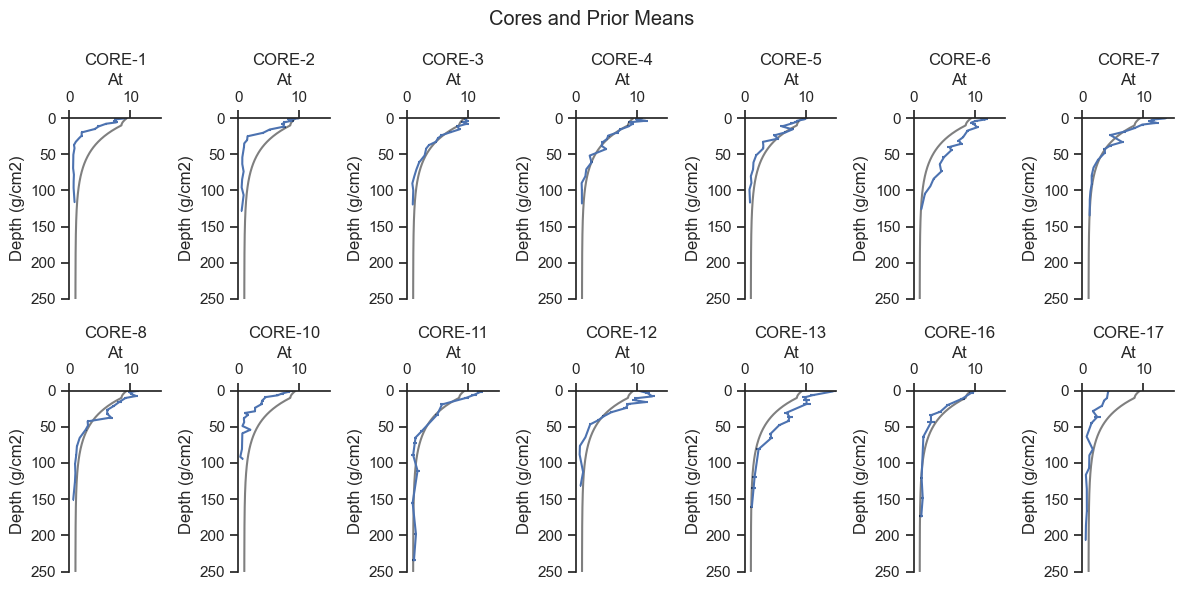

In [99]:
model_line_kwargs = {'Phi_prior':10, 'ma_prior':10,  'w_prior':1}
plot_cores_w_model(cores, rows=2, cols=7, ylim = (250, 0), xlim = (0,15), figsize=(12, 6),
                 model_line_kwargs=model_line_kwargs, alpha=.5)
plt.suptitle('Cores and Prior Means')
plt.tight_layout()

Prior means are within the range.  Check prior distributions.  

## PYMC Non-Hierarchical Model

In [100]:
# prior means
Phi_prior=10
ma_prior=5
w_prior=1
s_prior=0.7
lam = np.log(2)/22.3
km_prior = 10

# wrangle
fit_data = data.dropna(subset=['Pb210']).copy()
cores = fit_data.Core.unique()
cores
core_idxs = list(range(len(cores)))
core_map = dict(zip(cores, core_idxs))
core_map
no_cores = len(fit_data.Core.unique())
fit_data['Core_idx'] = fit_data.Core.replace(core_map)
core_idx  = fit_data.Core_idx
x = fit_data.Median_mass_g_cm2.values
y = fit_data.Pb210.values
y_err =fit_data.Pb210_Err.values

In [101]:
def analytical_model(w, Phi, ma, km, s, core_idx, mass_depth):
    
    # analytical model equations - written to accept pymc variables
    xp = (w[core_idx] + (w[core_idx]**2 + 4 * lam * km[core_idx])**(1/2))/(2 * km[core_idx])
    xm = (w[core_idx] - (w[core_idx]**2 + 4 * lam * km[core_idx])**(1/2))/(2 * km[core_idx])
    eps = xm / xp * pm.math.exp((xm-xp)*ma[core_idx])
    Gamp = w[core_idx] - km[core_idx] * xp
    Gamm = w[core_idx] - km[core_idx] * xm
    Cm = Phi[core_idx] / (Gamm - eps * Gamp)
    Cp = - eps * Cm
    CII = (pm.math.exp(xm * ma[core_idx]) - eps * pm.math.exp(xp * ma[core_idx]) 
            ) * Cm / pm.math.exp(-lam  * ma[core_idx] / w[core_idx])
    
    # Ct is the prediction 
    # select correct equation on either side of ma
    Ct = pm.math.switch(ma[core_idx] > mass_depth,
        Cp  * pm.math.exp(xp * mass_depth) + Cm * pm.math.exp(xm * mass_depth) + s[core_idx],
        CII * pm.math.exp(-lam * mass_depth / w[core_idx]) + s[core_idx])
    return Ct


In [114]:

model = pm.Model()
with model:
    # data
    core_idx = pm.MutableData('core_idx', fit_data.Core_idx.values)
    mass_depth = pm.MutableData('mass_depth', fit_data.Median_mass_g_cm2.values )
    obs_pb210 = pm.MutableData('obs_pb210', fit_data.Pb210.values )
    measurement_err_pb210 = pm.MutableData('measurement_err_pb210', fit_data.Pb210_Err.values )

    # Priors for unknown model parameters
    w = pm.TruncatedNormal('w', mu = w_prior, sigma = w_prior,  lower=0.05, shape=no_cores)   # g/cm2/yr
    Phi = pm.TruncatedNormal('Phi', mu = Phi_prior, sigma = Phi_prior, lower=0.1,  shape=no_cores)     # dpm/cm2/yr
    ma = pm.TruncatedNormal('ma', mu = ma_prior, sigma = ma_prior/2, lower=0, upper=15, shape=no_cores) 
    km = pm.TruncatedNormal('km', mu = km_prior, sigma = km_prior/2, lower=0, shape=no_cores)         # g2/cm4/yr
    s = pm.TruncatedNormal('s', mu = s_prior, sigma = s_prior/2, lower=0, shape=no_cores)

    Ct = analytical_model(w, Phi, ma, km, s, core_idx, mass_depth)
  
    # sampling error - added to measurement error for each core
    sigma = pm.HalfNormal('sigma', sigma=1, shape=no_cores)  
    
    # Likelihood (sampling distribution) of observations
    y_pred = pm.Normal('y_pred', mu=Ct, sigma=measurement_err_pb210 + sigma[core_idx],  observed=obs_pb210)

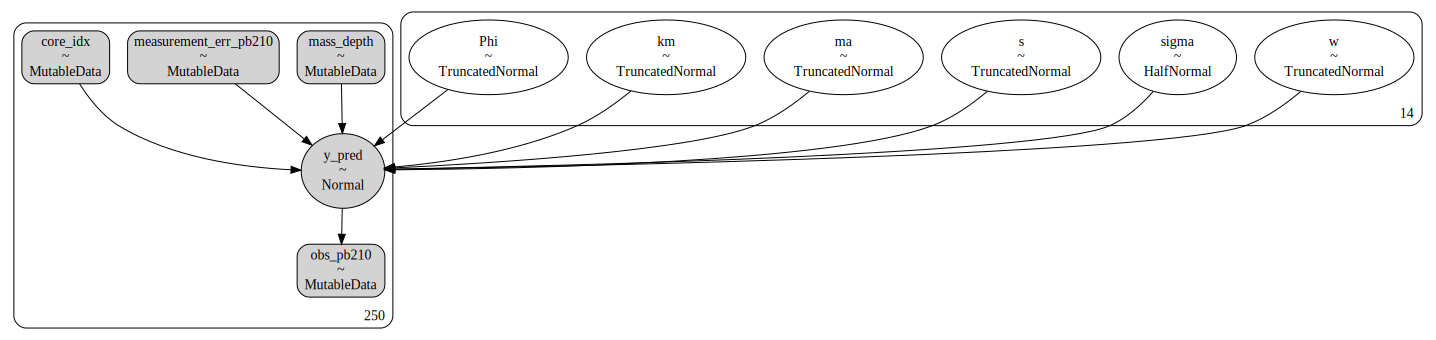

In [115]:
pm.model_to_graphviz(model)

In [116]:
with model:
    prior = pm.sample_prior_predictive(50)

In [117]:
params = ['w','Phi','ma', 'km', 's']
prior_df = pd.DataFrame()
for param in params:
    prior_df[param] = prior.prior[param].values.flatten()
prior_df;

In [118]:
def make_model_lines(
                        ylim=(250, 0),  # set up the mass depth array
                        w = 0.2,                       # deposition rate g/cm2/yr
                        Phi = .4,                       # loading rate dpm/cm2/yr
                        ma = 7.5 ,                    # depth of mixing g/cm2
                        km = 10,
                        s = 1):
    mass_depth = np.linspace(ylim[1], ylim[0],200)
    # diffusion coefficient g2/cm4/yr
    ma, xp, xm, Cm, Cp, CII, lam, w  = A_calc_coeffs(w, Phi, ma, km)
    At = vect_A_calc(mass_depth, ma, xp, xm, Cm, Cp, CII, lam, w , s)

    priors = pd.DataFrame()
    priors['mass_depth'] = mass_depth
    priors['At'] = At
    return priors


In [119]:
def plot_cores_w_model(cores, rows, cols, ylim, xlim, figsize, model_line_kwargs_list, alpha=1):
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    for ax, core in zip(axes.flatten(), cores):
        plot_core_ax(data[data.Core==core], ax, 'Pb210', 'Median_mass_g_cm2', 
                    title=core, legend=False, err_plot=True)
        for model_line_kwargs in model_line_kwargs_list:
            make_model_lines(**model_line_kwargs).plot(
                ax = ax, x = 'At', y = 'mass_depth', color='black', alpha=alpha)
        ax.set_ylim(ylim)
        ax.set_xlim(xlim)
        ax.get_legend().remove()
    plt.tight_layout()
        

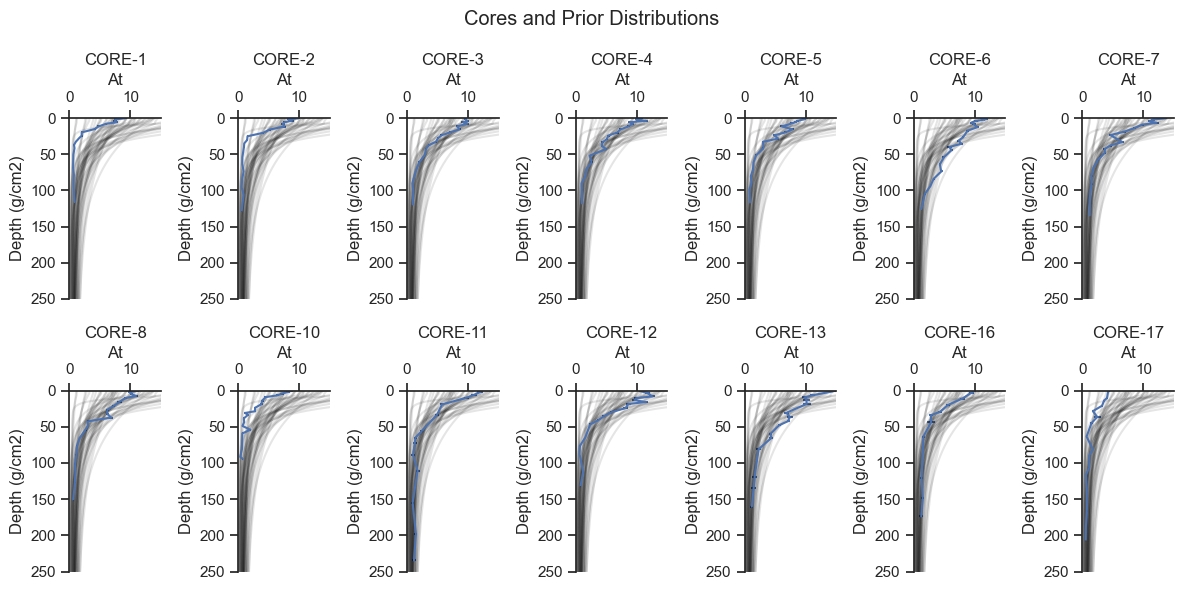

In [120]:
model_line_kwargs_list = [dict(prior_df.loc[i]) for i in range(50)]
plot_cores_w_model(cores, rows=2, cols=7, ylim = (250, 0), xlim = (0,15), figsize=(12, 6),
                 model_line_kwargs_list=model_line_kwargs_list, alpha=.1)
plt.suptitle('Cores and Prior Distributions')
plt.tight_layout()

The prior means encompass the data.  Plot with error.  

In [121]:
pp_df = pd.DataFrame(prior.prior_predictive.y_pred.values[0].T)
pp_df
pp_df['Core'] = fit_data.Core.values
pp_df['Median_mass_g_cm2'] = fit_data.Median_mass_g_cm2.values
pp_df.head();

In [122]:
def plot_cores_w_predictive(cores, rows, cols, ylim, xlim, figsize):
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    for ax, core in zip(axes.flatten(), cores):
        pp_df[pp_df.Core==core].melt(id_vars = ['Core', 'Median_mass_g_cm2']
            ).plot.scatter('value', 'Median_mass_g_cm2', ax=ax, color='black', alpha=.1)
        plot_core_ax(data[data.Core==core], ax, 'Pb210', 'Median_mass_g_cm2', 
                    title=core, legend=False, err_plot=True)
        ax.set_ylim(ylim)
        ax.set_xlim(xlim)
    plt.tight_layout()
        

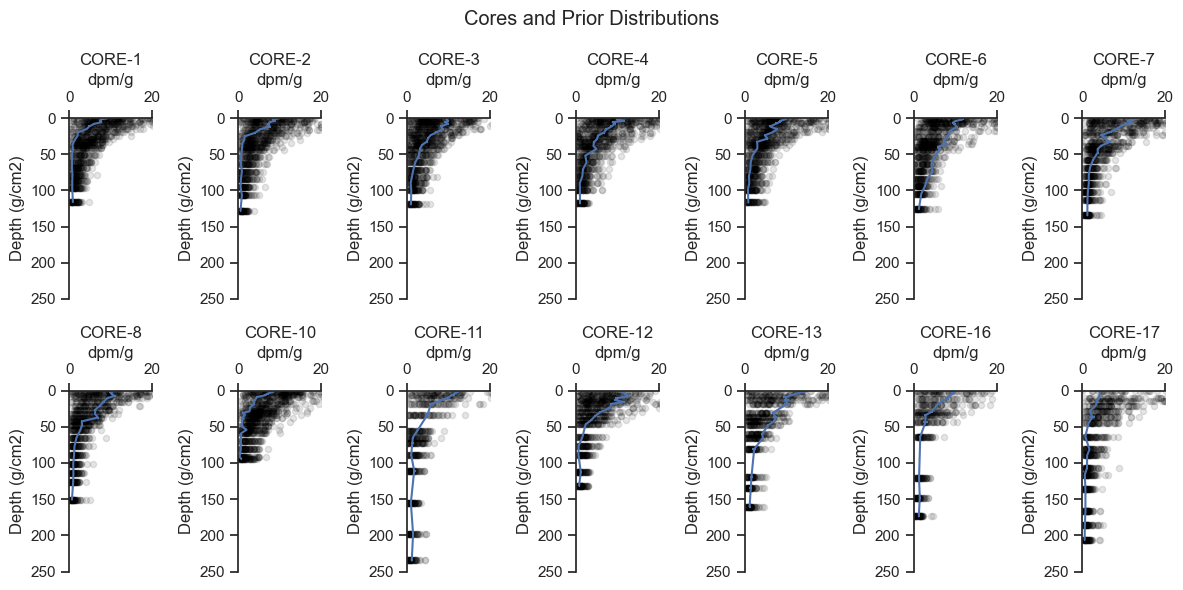

In [123]:
plot_cores_w_predictive(cores, rows=2, cols=7, ylim = (250, 0), xlim = (0,20), figsize=(12, 6))
plt.suptitle('Cores and Prior Distributions')
plt.tight_layout()

The prior predictive values encompass the data and can be considered weakly informative.  

### Sample and Evaluate Posterior

In [124]:
with model:
    trace = pm.sample(target_accept=.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, Phi, ma, km, s, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 212 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


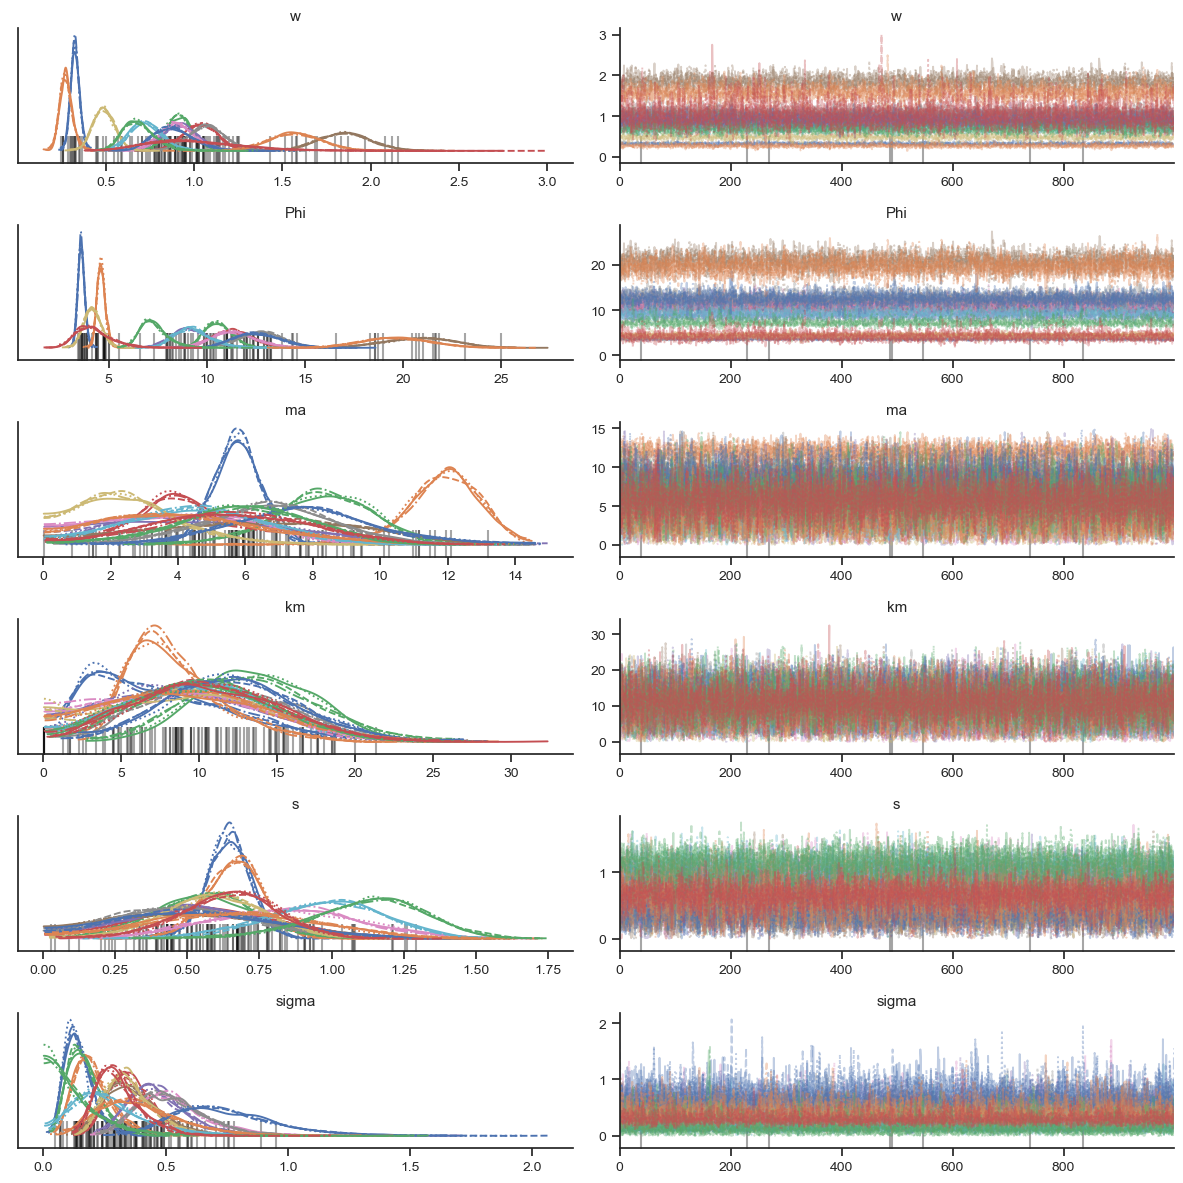

In [145]:
az.plot_trace(trace)
sns.despine()
plt.tight_layout()

In [128]:
summary = az.summary(trace)
summary[summary.r_hat > 1.00]

mean    sd    hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
km[9]  10.008  4.674   1.19   18.473     0.079     0.056    3177.0    1850.0    

       r_hat  
km[9]  1.01

In [135]:
def posterior_plot(x, y, trace, n, ax, core_idx, 
                   xmax = 25, 
                   title = 'title', 
             xlabel = 'Pb210XS_dpm_g',
             ylabel = 'Cum_Mass_Med_g_cm2'):
    
    ax.plot(y, x, 'o')  # data plot
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    mass_depth = np.linspace(0,xmax,100)
    random_idxs = np.random.choice(range(4000), n)
    for idx in random_idxs:
        ma, xp, xm, Cm, Cp, CII, lam, w  = A_calc_coeffs(
            w = trace.posterior['w'].values.reshape(4000, 14)[:,core_idx][idx], 
            Phi = trace.posterior['Phi'].values.reshape(4000, 14)[:,core_idx][idx],
            ma = trace.posterior['ma'].values.reshape(4000, 14)[:,core_idx][idx], 
            km = trace.posterior['km'].values.reshape(4000, 14)[:,core_idx][idx],)
        At = vect_A_calc(mass_depth, ma, xp, xm, Cm, Cp, CII, lam, w, 
            s = trace.posterior['s'].values.reshape(4000, 14)[:,core_idx][idx])
        ax.plot(At , mass_depth,  c = 'black', alpha = .1)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')

    ax.set_title(title)
    ax.invert_yaxis()
    

In [143]:
def posterior_plot_grid(cores, rows, cols, ylim, xlim, figsize, n=50):
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    for ax, core in zip(axes.flatten(), cores):
        x = fit_data[fit_data.Core==core].Median_mass_g_cm2.values
        y = fit_data[fit_data.Core==core].Pb210.values
        posterior_plot(x,y,trace, n, ax, core_idx = core_map[core], title=core, xmax=250)
        ax.set_ylim(ylim)
        ax.set_xlim(xlim)
        ax.set_ylabel('Depth (g/cm2)')
        ax.set_xlabel('dpm/g')

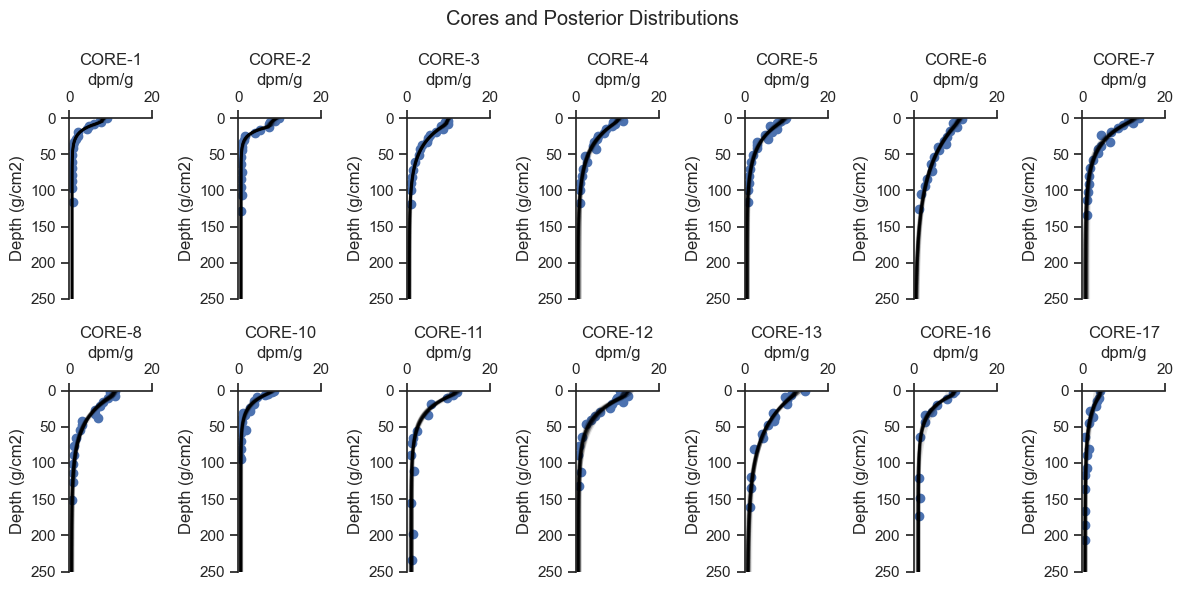

In [146]:
posterior_plot_grid(cores, rows=2, cols=7, ylim = (250, 0), xlim = (0,20), figsize=(12, 6), n=50)
plt.suptitle('Cores and Posterior Distributions')
plt.tight_layout()

## Hierarchical Model to Support

In [149]:
def adaptive_noncentered_norm_norm_exp(name, mu_mu, mu_sigma, sigma_mu, shape, lower=None, upper=None):
    sigma = pm.Exponential(name+'_sigma', lam=1/sigma_mu, initval=sigma_mu)
    mu = pm.TruncatedNormal(name+'_mu', mu=mu_mu, sigma=mu_sigma, lower=lower, upper=upper , initval=mu_mu)
    sampled_sigma_multiplier = pm.Normal(name+'_sampled_sigma_mult', 0, 1, shape=shape, initval=[0]*shape)
    dist = pm.Deterministic(name, mu + sigma * sampled_sigma_multiplier)
    if lower==None:
        lower = -np.inf
    if upper==None:
        upper = np.inf
    pm.Potential(name+'_check_limits', pm.math.switch(pm.math.lt(dist, lower), -np.inf,
                                        pm.math.switch(pm.math.gt(dist, upper), -np.inf, 0)))
    return dist

In [150]:

model = pm.Model()
with model:
    # data
    core_idx = pm.MutableData('core_idx', fit_data.Core_idx.values)
    mass_depth = pm.MutableData('mass_depth', fit_data.Median_mass_g_cm2.values )
    obs_pb210 = pm.MutableData('obs_pb210', fit_data.Pb210.values )
    measurement_err_pb210 = pm.MutableData('measurement_err_pb210', fit_data.Pb210_Err.values )

    # Priors for unknown model parameters
    w = pm.TruncatedNormal('w', mu = w_prior, sigma = w_prior,  lower=0.05, shape=no_cores)   # g/cm2/yr
    Phi = pm.TruncatedNormal('Phi', mu = Phi_prior, sigma = Phi_prior, lower=0.1,  shape=no_cores)     # dpm/cm2/yr
    ma = pm.TruncatedNormal('ma', mu = ma_prior, sigma = ma_prior/2, lower=0, upper=15, shape=no_cores) 
    km = pm.TruncatedNormal('km', mu = km_prior, sigma = km_prior/2, lower=0, shape=no_cores)         # g2/cm4/yr
    s = adaptive_noncentered_norm_norm_exp('s', mu_mu = s_prior, mu_sigma = s_prior/3, sigma_mu=s_prior/3, 
                            lower=0, shape=no_cores)

    Ct = analytical_model(w, Phi, ma, km, s, core_idx, mass_depth)
  
    # sampling error - added to measurement error for each core
    sigma = pm.HalfNormal('sigma', sigma=1, shape=no_cores)  
    
    # Likelihood (sampling distribution) of observations
    y_pred = pm.Normal('y_pred', mu=Ct, sigma=measurement_err_pb210 + sigma[core_idx],  observed=obs_pb210)

In [151]:
model

                   w ~ TruncatedNormal(1, 1, 0.05, inf)
                 Phi ~ TruncatedNormal(10, 10, 0.1, inf)
                  ma ~ TruncatedNormal(5, 2.5, 0, 15)
                  km ~ TruncatedNormal(10, 5, 0, inf)
             s_sigma ~ Exp(f())
                s_mu ~ TruncatedNormal(0.7, 0.233, 0, inf)
s_sampled_sigma_mult ~ N(0, 1)
               sigma ~ N**+(0, 1)
                   s ~ Deterministic(f(s_sampled_sigma_mult, s_mu, s_sigma))
              y_pred ~ N(f(ma, s_sampled_sigma_mult, s_mu, Phi, w, s_sigma, km), f(sigma))
      s_check_limits ~ Potential(f(s_sampled_sigma_mult, s_mu, s_sigma))

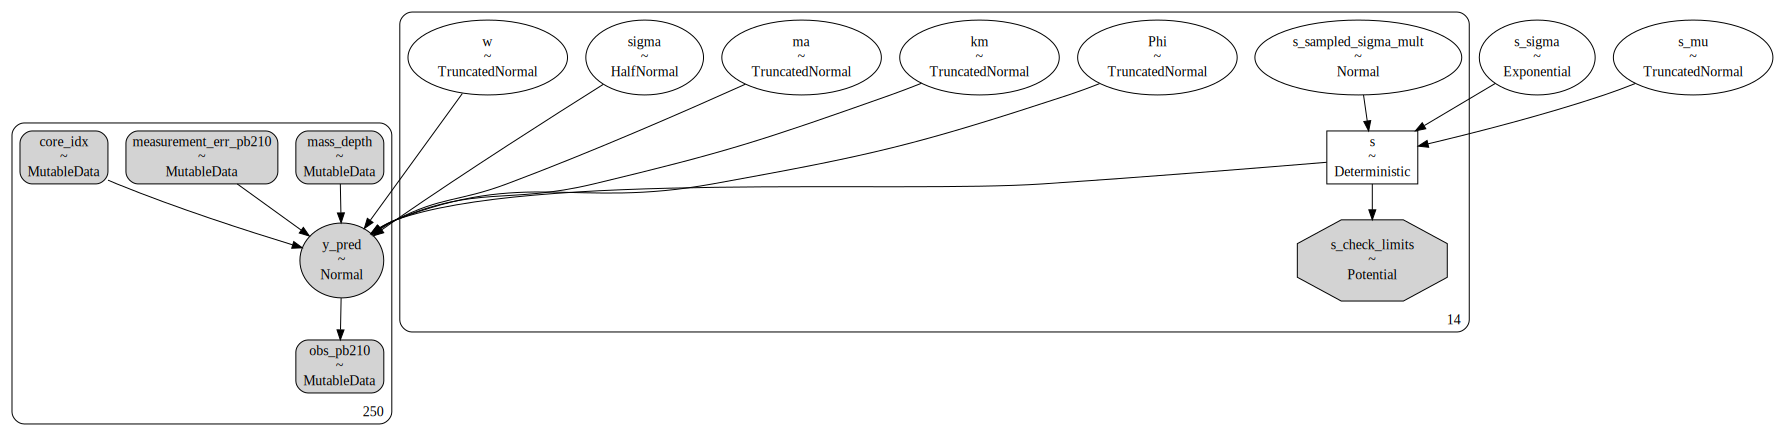

In [152]:
pm.model_to_graphviz(model)

In [153]:
with model:
    prior = pm.sample_prior_predictive(50)

C:\Users\greg\AppData\Local\Temp\ipykernel_8648\4291002478.py:2: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  prior = pm.sample_prior_predictive(50)


In [154]:
params = ['w','Phi','ma', 'km', 's']
prior_df = pd.DataFrame()
for param in params:
    prior_df[param] = prior.prior[param].values.flatten()
prior_df;

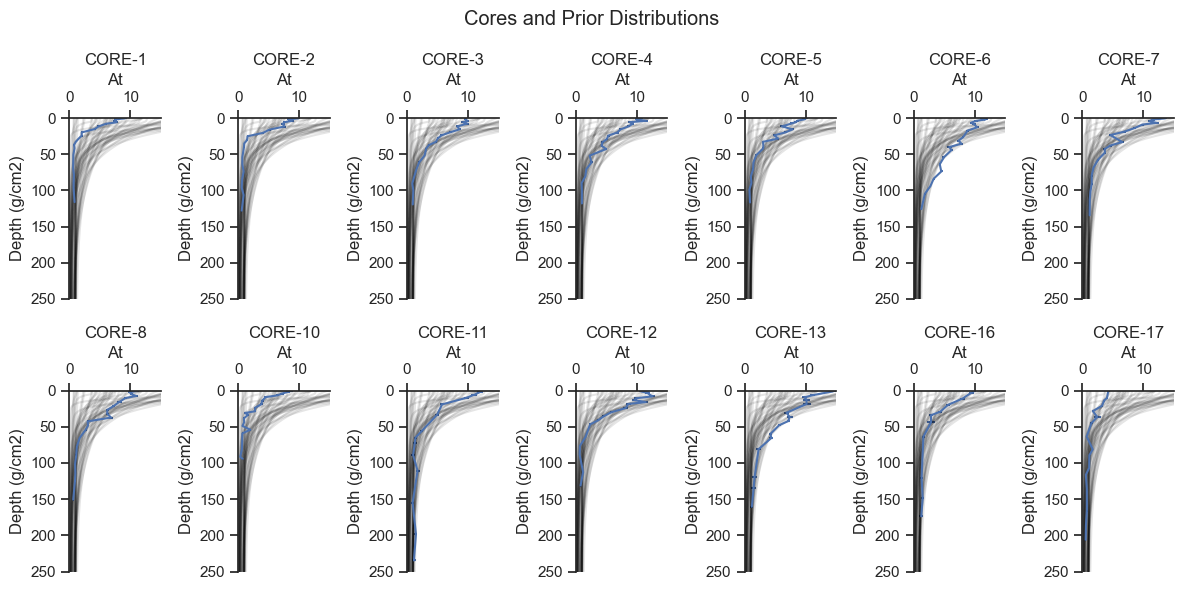

In [155]:
model_line_kwargs_list = [dict(prior_df.loc[i]) for i in range(50)]
plot_cores_w_model(cores, rows=2, cols=7, ylim = (250, 0), xlim = (0,15), figsize=(12, 6),
                 model_line_kwargs_list=model_line_kwargs_list, alpha=.1)
plt.suptitle('Cores and Prior Distributions')
plt.tight_layout()

In [156]:
pp_df = pd.DataFrame(prior.prior_predictive.y_pred.values[0].T)
pp_df
pp_df['Core'] = fit_data.Core.values
pp_df['Median_mass_g_cm2'] = fit_data.Median_mass_g_cm2.values
pp_df.head();

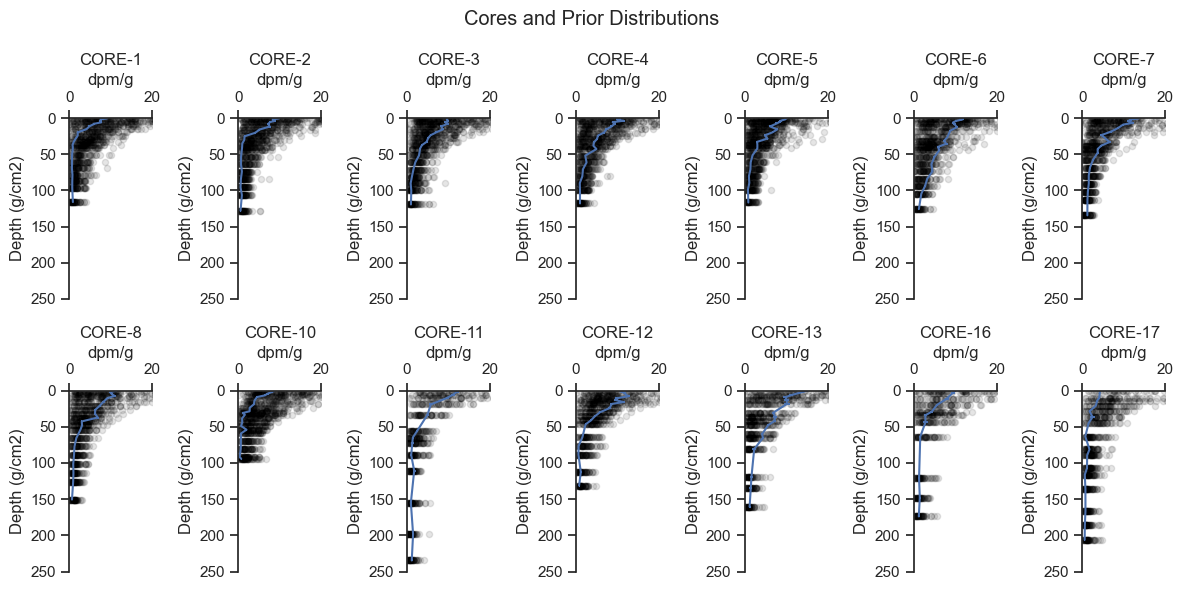

In [157]:
plot_cores_w_predictive(cores, rows=2, cols=7, ylim = (250, 0), xlim = (0,20), figsize=(12, 6))
plt.suptitle('Cores and Prior Distributions')
plt.tight_layout()

### Sample and Evaluate Posterior

In [158]:
with model:
    trace = pm.sample(target_accept=.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, Phi, ma, km, s_sigma, s_mu, s_sampled_sigma_mult, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 348 seconds.
There were 131 divergences after tuning. Increase `target_accept` or reparameterize.
There were 108 divergences after tuning. Increase `target_accept` or reparameterize.
There were 73 divergences after tuning. Increase `target_accept` or reparameterize.
There were 95 divergences after tuning. Increase `target_accept` or reparameterize.


In [170]:
trace.sel(chain=0)

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

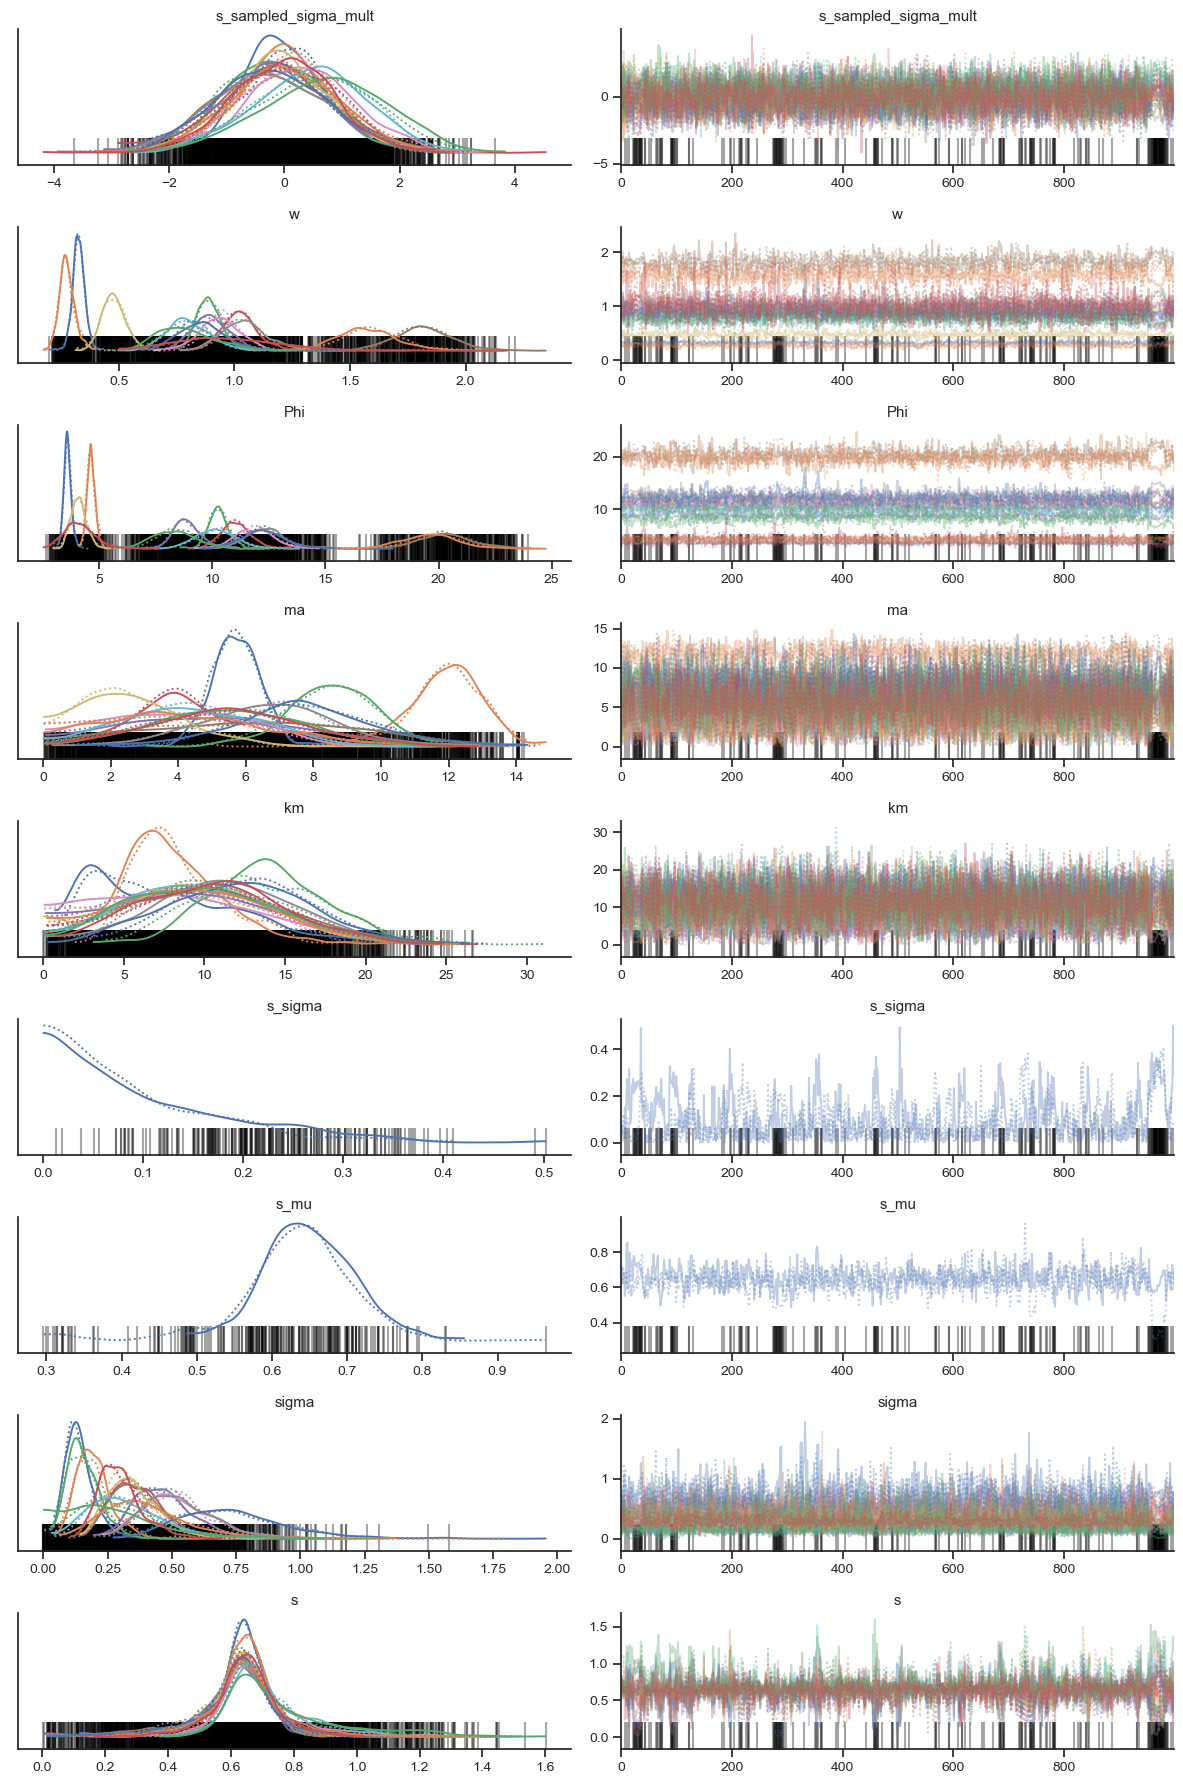

In [171]:
az.plot_trace(trace.sel(chain=[0,1]))
sns.despine()
plt.tight_layout()

In [160]:
summary = az.summary(trace)
summary[summary.r_hat > 1.00]

mean    sd    hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
w[13]     0.995  0.242   0.567   1.445     0.008     0.006    1014.0    
Phi[5]   20.277  1.132  18.248  22.581     0.031     0.022    1342.0    
Phi[6]   11.926  0.836  10.328  13.504     0.022     0.016    1441.0    
Phi[13]   4.210  0.737   2.905   5.572     0.026     0.020    1013.0    
km[8]     9.519  4.914   0.006  17.295     0.132     0.093    1233.0    
s_sigma   0.095  0.084   0.000   0.253     0.004     0.003     496.0    
s_mu      0.644  0.068   0.518   0.771     0.003     0.002     846.0    
s[4]      0.617  0.128   0.333   0.845     0.004     0.003    1316.0    
s[5]      0.618  0.135   0.304   0.857     0.005     0.003    1175.0    
s[6]      0.675  0.128   0.446   0.939     0.004     0.003    1011.0    
s[7]      0.611  0.132   0.335   0.849     0.005     0.004     965.0    
s[9]      0.709  0.134   0.482   0.989     0.004     0.003    1026.0    
s[12]     0.737  0.170   0.508   1.136     0.008     0.006     640.0    

         ess_tail  r_hat  
w[13]      885.0   1.01   
Phi[5]    1027.0   1.01   
Phi[6]    1471.0   1.01   
Phi[13]    836.0   1.01   
km[8]      770.0   1.01   
s_sigma    636.0   1.01   
s_mu       513.0   1.01   
s[4]       803.0   1.01   
s[5]       685.0   1.01   
s[6]      1202.0   1.01   
s[7]       602.0   1.01   
s[9]      1473.0   1.01   
s[12]      711.0   1.01

In [220]:
vars = ['s_sigma', 's_mu']
vars_df = trace.sel(chain=0, draw=slice(900, None)).posterior[vars].to_dataframe()
vars_df
vars_df.index
vars = ['s']
s_df = trace.sel(chain=0, draw=slice(900, None)).posterior[vars].to_dataframe()
s_df = s_df.reset_index().pivot(columns='s_dim_0', index='draw', values='s')
s_df.columns = ['s'+str(n) for n in range(len(s_df.columns))]
s_df.index
sample_stats_df  = trace.sel(chain=0, draw=slice(900, None)).sample_stats.to_dataframe()
sample_stats_df.columns
sample_stats_df= pd.concat([vars_df, s_df, sample_stats_df], axis=1)
sample_stats_df

s_sigma    s_mu    chain     s0        s1        s2        s3     \
draw                                                                      
900   0.024963  0.583640    0    0.609162  0.603143  0.612767  0.539244   
901   0.025796  0.649057    0    0.640902  0.626959  0.617047  0.693772   
902   0.074111  0.635853    0    0.692262  0.807522  0.700545  0.489959   
903   0.002554  0.688875    0    0.693599  0.692009  0.690245  0.691178   
904   0.076776  0.598016    0    0.625152  0.568229  0.523054  0.630500   
...        ...       ...    ...       ...       ...       ...       ...   
995   0.237727  0.688497    0    0.647945  0.745875  0.592595  0.655791   
996   0.231597  0.729687    0    0.766374  0.656498  0.449388  0.529637   
997   0.447938  0.674526    0    0.538840  0.714597  0.641075  0.203232   
998   0.502157  0.705906    0    0.609321  0.710663  0.755695  0.297238   
999   0.286289  0.607473    0    0.612879  0.670533  0.440274  0.588518   

         s4        s5        s6     ...  smallest_eigval  diverging  \
draw                                ...                               
900   0.572309  0.578113  0.560244  ...       NaN           False     
901   0.655101  0.664254  0.672842  ...       NaN           False     
902   0.566049  0.717528  0.695033  ...       NaN           False     
903   0.688548  0.688231  0.689663  ...       NaN           False     
904   0.596500  0.558191  0.591017  ...       NaN           False     
...        ...       ...       ...  ...              ...        ...   
995   0.314726  0.463942  0.970874  ...       NaN           False     
996   0.741792  0.527905  0.362911  ...       NaN           False     
997   0.751936  0.730379  0.337291  ...       NaN           False     
998   0.784951  0.908284  0.219610  ...       NaN            True     
999   0.622391  0.698958  0.461620  ...       NaN           False     

      largest_eigval  index_in_trajectory  acceptance_rate      lp      \
draw                                                                     
900        NaN               -48              0.983270     -294.710999   
901        NaN                49              0.844667     -303.378917   
902        NaN                36              0.993882     -297.465612   
903        NaN               -33              0.986359     -298.333171   
904        NaN               -37              0.958913     -296.216439   
...              ...                  ...              ...         ...   
995        NaN                47              0.984907     -309.125705   
996        NaN                38              0.989044     -305.241061   
997        NaN                31              0.991102     -302.102467   
998        NaN                -5              0.932277     -294.686635   
999        NaN                43              0.854196     -308.794419   

      process_time_diff  step_size  n_steps  energy_error  
draw                                                       
900       0.109375       0.056184     63.0    -0.056706    
901       0.078125       0.056184     63.0     0.228584    
902       0.109375       0.056184     63.0    -0.073067    
903       0.109375       0.056184     63.0    -0.037800    
904       0.078125       0.056184     63.0     0.066924    
...                 ...        ...      ...           ...  
995       0.093750       0.056184     63.0    -0.045527    
996       0.171875       0.056184    127.0    -0.245958    
997       0.093750       0.056184     63.0    -0.155767    
998       0.031250       0.056184     17.0    -0.060239    
999       0.093750       0.056184     63.0     0.209548    

[100 rows x 34 columns]

<AxesSubplot:xlabel='diverging', ylabel='s_sigma'>

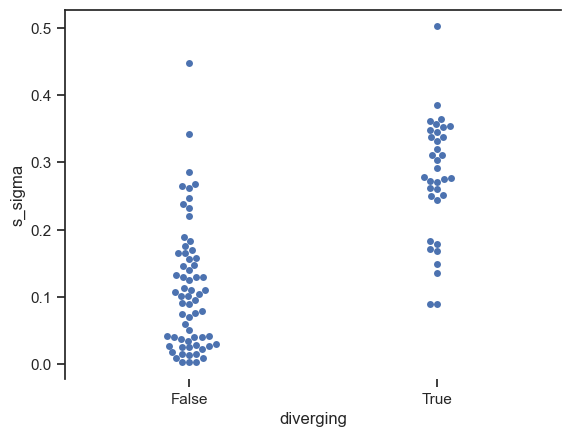

In [223]:
sns.swarmplot(data=sample_stats_df, y='s_sigma', x='diverging')

<AxesSubplot:xlabel='diverging', ylabel='s_mu'>

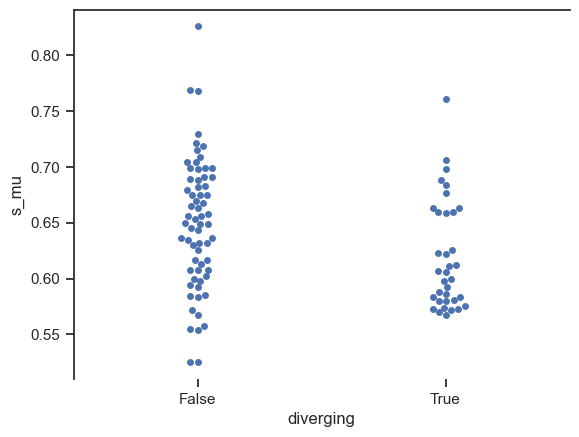

In [224]:
sns.swarmplot(data=sample_stats_df, y='s_mu', x='diverging')

<AxesSubplot:xlabel='diverging', ylabel='s0'>

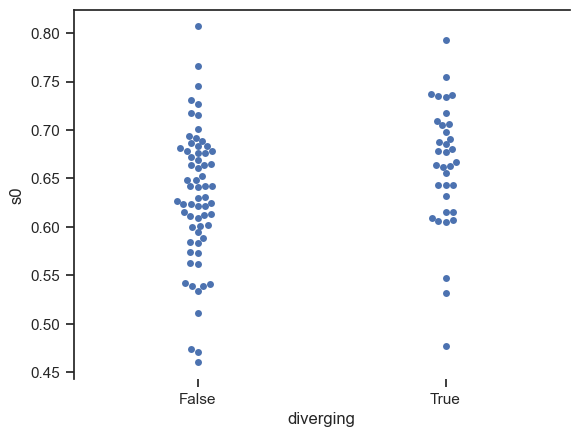

In [226]:
sns.swarmplot(data=sample_stats_df, y='s0', x='diverging')

In [227]:
summary = az.summary(trace)
summary[summary.r_hat > 1.00]

mean    sd    hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
w[13]     0.995  0.242   0.567   1.445     0.008     0.006    1014.0    
Phi[5]   20.277  1.132  18.248  22.581     0.031     0.022    1342.0    
Phi[6]   11.926  0.836  10.328  13.504     0.022     0.016    1441.0    
Phi[13]   4.210  0.737   2.905   5.572     0.026     0.020    1013.0    
km[8]     9.519  4.914   0.006  17.295     0.132     0.093    1233.0    
s_sigma   0.095  0.084   0.000   0.253     0.004     0.003     496.0    
s_mu      0.644  0.068   0.518   0.771     0.003     0.002     846.0    
s[4]      0.617  0.128   0.333   0.845     0.004     0.003    1316.0    
s[5]      0.618  0.135   0.304   0.857     0.005     0.003    1175.0    
s[6]      0.675  0.128   0.446   0.939     0.004     0.003    1011.0    
s[7]      0.611  0.132   0.335   0.849     0.005     0.004     965.0    
s[9]      0.709  0.134   0.482   0.989     0.004     0.003    1026.0    
s[12]     0.737  0.170   0.508   1.136     0.008     0.006     640.0    

         ess_tail  r_hat  
w[13]      885.0   1.01   
Phi[5]    1027.0   1.01   
Phi[6]    1471.0   1.01   
Phi[13]    836.0   1.01   
km[8]      770.0   1.01   
s_sigma    636.0   1.01   
s_mu       513.0   1.01   
s[4]       803.0   1.01   
s[5]       685.0   1.01   
s[6]      1202.0   1.01   
s[7]       602.0   1.01   
s[9]      1473.0   1.01   
s[12]      711.0   1.01

<AxesSubplot:xlabel='s_mu', ylabel='s_sigma'>

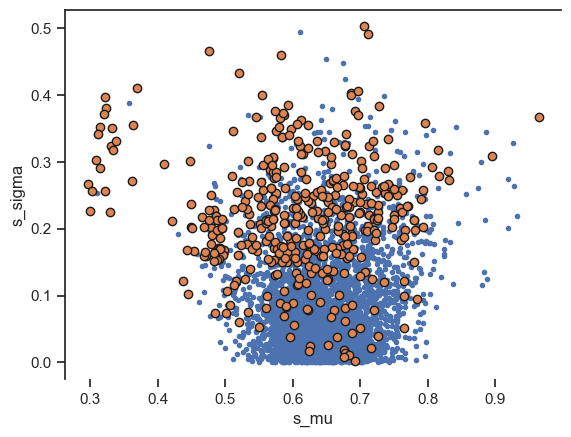

In [229]:
var_names = ['s_mu', 's_sigma']
az.plot_pair(trace, divergences=True, var_names=var_names)

Sampling issues appear to be with the truncated normal parameterization.  High values of sigma create an issue.   

### Centered Parameterization

In [233]:
def adaptive_norm_norm_exp(name, mu_mu, mu_sigma, sigma_mu, shape, lower=None, upper=None):
    sigma = pm.Exponential(name+'_sigma', lam=1/sigma_mu, initval=sigma_mu)
    mu = pm.Normal(name+'_mu', mu=mu_mu, sigma=mu_sigma, initval=mu_mu)
    dist = pm.TruncatedNormal(name, mu=mu, sigma=sigma,  lower=lower, upper=upper, shape=shape)
    return dist

In [234]:

model = pm.Model()
with model:
    # data
    core_idx = pm.MutableData('core_idx', fit_data.Core_idx.values)
    mass_depth = pm.MutableData('mass_depth', fit_data.Median_mass_g_cm2.values )
    obs_pb210 = pm.MutableData('obs_pb210', fit_data.Pb210.values )
    measurement_err_pb210 = pm.MutableData('measurement_err_pb210', fit_data.Pb210_Err.values )

    # Priors for unknown model parameters
    w = pm.TruncatedNormal('w', mu = w_prior, sigma = w_prior,  lower=0.05, shape=no_cores)   # g/cm2/yr
    Phi = pm.TruncatedNormal('Phi', mu = Phi_prior, sigma = Phi_prior, lower=0.1,  shape=no_cores)     # dpm/cm2/yr
    ma = pm.TruncatedNormal('ma', mu = ma_prior, sigma = ma_prior/2, lower=0, upper=15, shape=no_cores) 
    km = pm.TruncatedNormal('km', mu = km_prior, sigma = km_prior/2, lower=0, shape=no_cores)         # g2/cm4/yr
    s = adaptive_norm_norm_exp('s', mu_mu = s_prior, mu_sigma = s_prior/3, sigma_mu=s_prior/3, 
                            lower=0, shape=no_cores)

    Ct = analytical_model(w, Phi, ma, km, s, core_idx, mass_depth)
  
    # sampling error - added to measurement error for each core
    sigma = pm.HalfNormal('sigma', sigma=1, shape=no_cores)  
    
    # Likelihood (sampling distribution) of observations
    y_pred = pm.Normal('y_pred', mu=Ct, sigma=measurement_err_pb210 + sigma[core_idx],  observed=obs_pb210)

In [235]:
model

      w ~ TruncatedNormal(1, 1, 0.05, inf)
    Phi ~ TruncatedNormal(10, 10, 0.1, inf)
     ma ~ TruncatedNormal(5, 2.5, 0, 15)
     km ~ TruncatedNormal(10, 5, 0, inf)
s_sigma ~ Exp(f())
   s_mu ~ N(0.7, 0.233)
      s ~ TruncatedNormal(s_mu, s_sigma, 0, inf)
  sigma ~ N**+(0, 1)
 y_pred ~ N(f(ma, s, Phi, w, km), f(sigma))

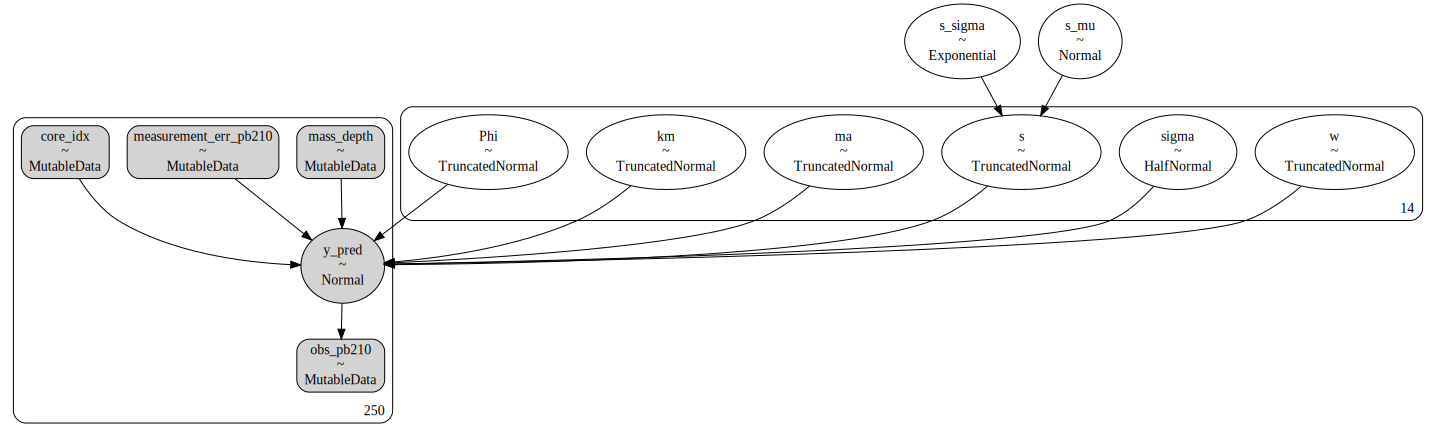

In [236]:
pm.model_to_graphviz(model)

In [237]:
with model:
    prior = pm.sample_prior_predictive(50)

In [238]:
params = ['w','Phi','ma', 'km', 's']
prior_df = pd.DataFrame()
for param in params:
    prior_df[param] = prior.prior[param].values.flatten()
prior_df;

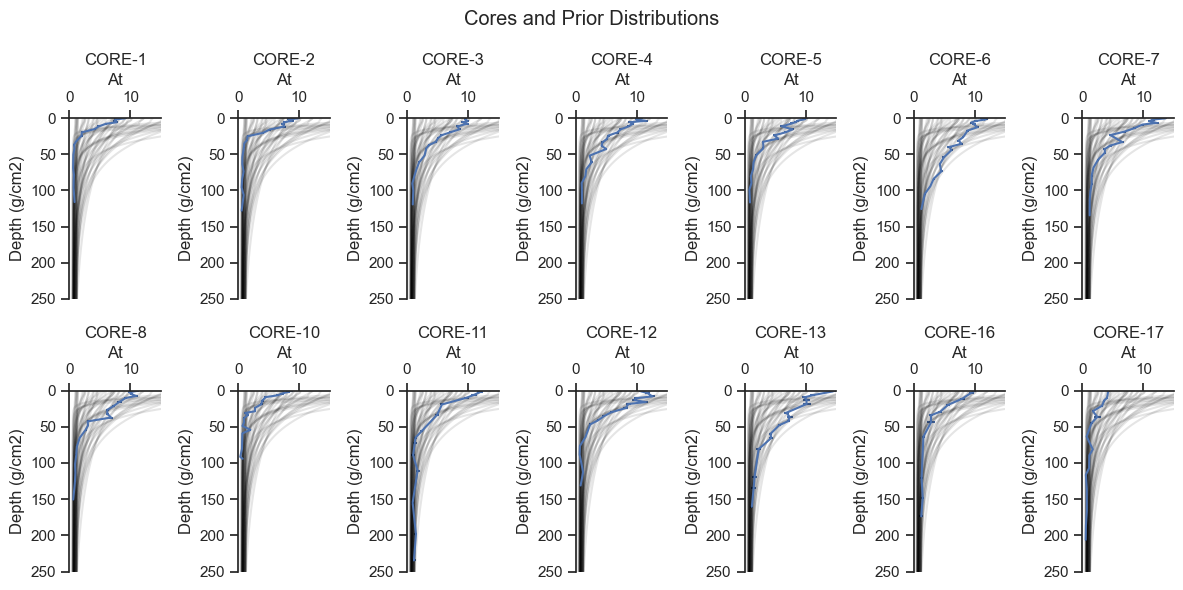

In [239]:
model_line_kwargs_list = [dict(prior_df.loc[i]) for i in range(50)]
plot_cores_w_model(cores, rows=2, cols=7, ylim = (250, 0), xlim = (0,15), figsize=(12, 6),
                 model_line_kwargs_list=model_line_kwargs_list, alpha=.1)
plt.suptitle('Cores and Prior Distributions')
plt.tight_layout()

In [240]:
pp_df = pd.DataFrame(prior.prior_predictive.y_pred.values[0].T)
pp_df
pp_df['Core'] = fit_data.Core.values
pp_df['Median_mass_g_cm2'] = fit_data.Median_mass_g_cm2.values
pp_df.head();

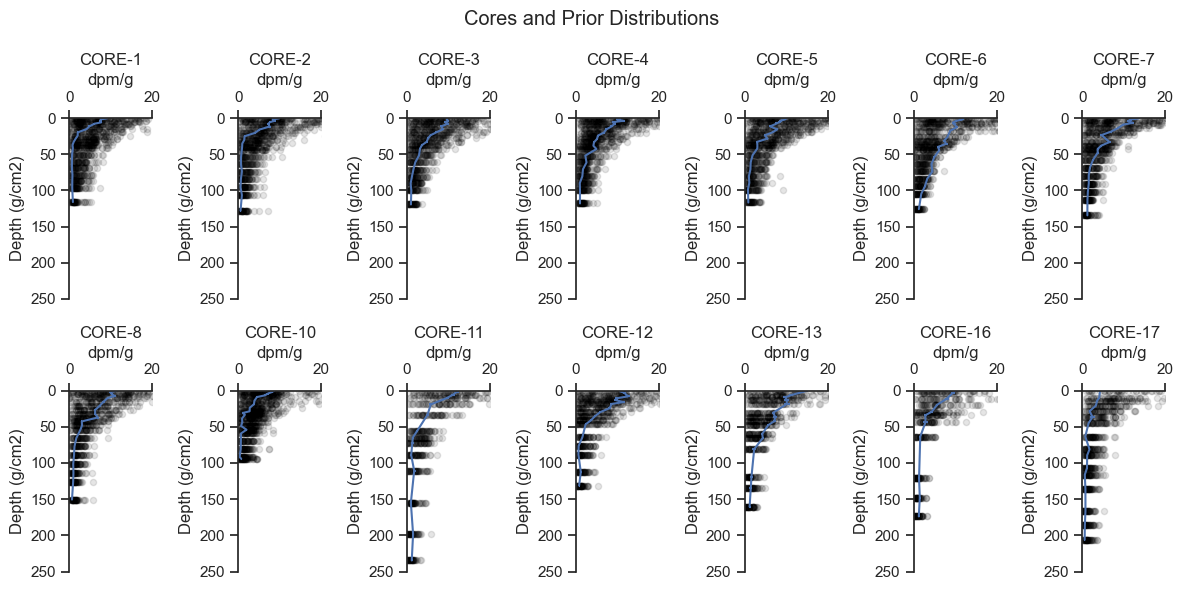

In [241]:
plot_cores_w_predictive(cores, rows=2, cols=7, ylim = (250, 0), xlim = (0,20), figsize=(12, 6))
plt.suptitle('Cores and Prior Distributions')
plt.tight_layout()

### Sample and Evaluate Posterior

In [242]:
with model:
    trace = pm.sample(target_accept=.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, Phi, ma, km, s_sigma, s_mu, s, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 690 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.862, but should be close to 0.95. Try to increase the number of tuning steps.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.


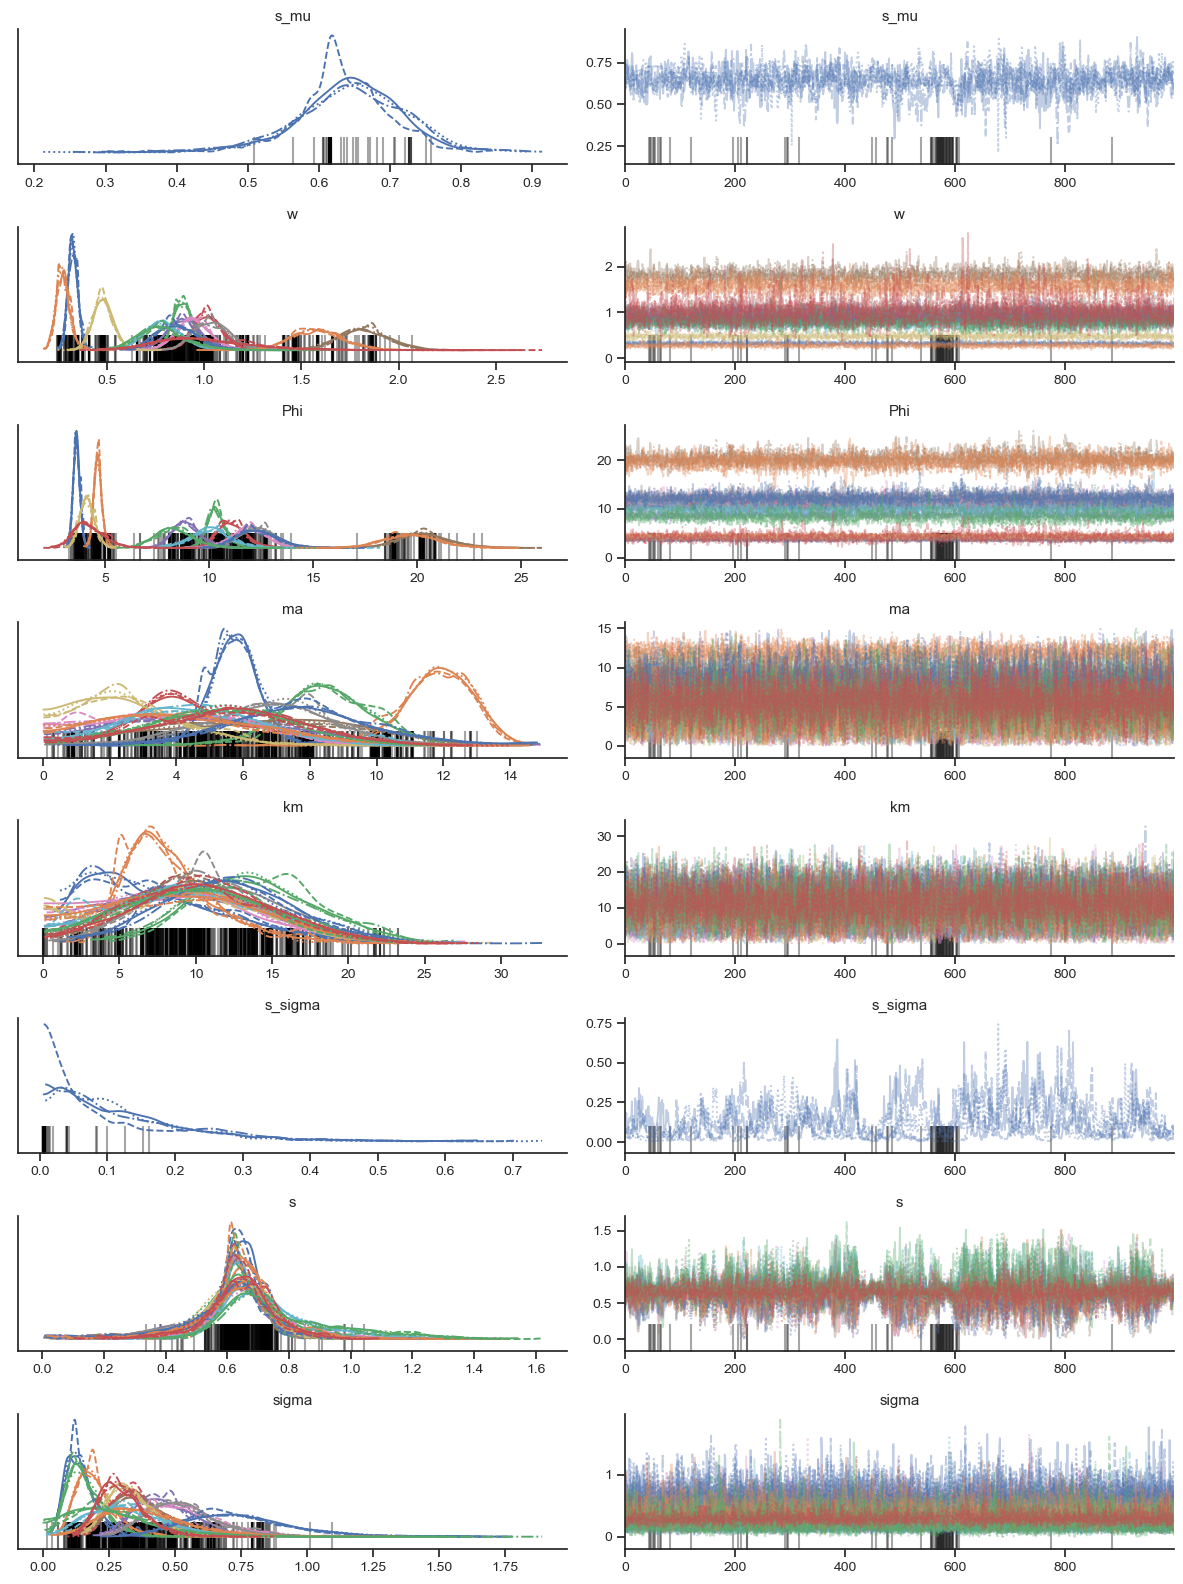

In [243]:
az.plot_trace(trace)
sns.despine()
plt.tight_layout()

In [244]:
summary = az.summary(trace)
summary[summary.r_hat > 1.00]

mean    sd    hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
s_mu       0.642  0.074   0.498   0.775     0.002     0.002     900.0    
w[7]       1.041  0.095   0.866   1.215     0.002     0.002    1832.0    
Phi[2]    10.350  0.486   9.494  11.317     0.014     0.010    1264.0    
Phi[8]     4.125  0.356   3.489   4.827     0.012     0.009     940.0    
Phi[9]    10.104  0.989   8.139  11.849     0.027     0.019    1262.0    
Phi[10]   12.301  1.008  10.491  14.166     0.030     0.022    1161.0    
Phi[12]    8.360  0.944   6.589  10.068     0.038     0.027     587.0    
ma[9]      4.589  2.124   0.240   8.182     0.070     0.070    1090.0    
ma[11]     4.249  2.509   0.066   8.525     0.038     0.028    3940.0    
km[1]      8.385  3.141   3.317  14.270     0.075     0.055    1540.0    
s_sigma    0.116  0.101   0.005   0.294     0.008     0.006     117.0    
s[0]       0.642  0.066   0.515   0.762     0.002     0.001    1630.0    
s[2]       0.613  0.113   0.395   0.822     0.004     0.003    1075.0    
s[3]       0.615  0.135   0.319   0.851     0.004     0.003    1463.0    
s[4]       0.602  0.146   0.271   0.848     0.006     0.004     864.0    
s[5]       0.607  0.157   0.280   0.918     0.005     0.004    1009.0    
s[6]       0.676  0.149   0.403   0.999     0.004     0.003    1445.0    
s[7]       0.602  0.143   0.275   0.829     0.005     0.004     847.0    
s[8]       0.622  0.113   0.406   0.847     0.003     0.002    1250.0    
s[9]       0.726  0.158   0.469   1.069     0.008     0.006     537.0    
s[10]      0.607  0.150   0.288   0.896     0.006     0.004     758.0    
s[11]      0.640  0.147   0.368   0.943     0.004     0.003    1307.0    
s[12]      0.761  0.191   0.480   1.175     0.011     0.008     396.0    
s[13]      0.640  0.113   0.409   0.859     0.003     0.002    1586.0    
sigma[5]   0.371  0.119   0.176   0.592     0.003     0.002    1265.0    

          ess_tail  r_hat  
s_mu        879.0   1.01   
w[7]       1641.0   1.01   
Phi[2]     1261.0   1.01   
Phi[8]     1291.0   1.01   
Phi[9]     1664.0   1.01   
Phi[10]    1077.0   1.01   
Phi[12]    1447.0   1.01   
ma[9]       237.0   1.01   
ma[11]     1939.0   1.01   
km[1]      1096.0   1.01   
s_sigma      83.0   1.04   
s[0]       1727.0   1.01   
s[2]        964.0   1.01   
s[3]       1078.0   1.01   
s[4]        605.0   1.01   
s[5]        657.0   1.01   
s[6]       1230.0   1.01   
s[7]        807.0   1.01   
s[8]       1150.0   1.01   
s[9]        987.0   1.01   
s[10]       560.0   1.02   
s[11]       769.0   1.01   
s[12]       936.0   1.01   
s[13]       921.0   1.01   
sigma[5]    275.0   1.01

### Centered Parameterization

In [279]:
def adaptive_gamma_gamma_exp(name, mu_mu, sigma_mu, shape):
    # alpha is the shape  - larger is more normal
    # beta is the rate - larger is a bigger mu

    alpha_init = mu_mu**2/sigma_mu**2
    beta_init = mu_mu/sigma_mu**2

    alpha = pm.Exponential(name+'_alpha', lam=1/alpha_init)
    beta = pm.Exponential(name+'_beta', lam=1/beta_init)

    dist = pm.Gamma(name, alpha=alpha, beta=beta, shape=shape)
    return dist

In [271]:

model = pm.Model()
with model:
    # data
    core_idx = pm.MutableData('core_idx', fit_data.Core_idx.values)
    mass_depth = pm.MutableData('mass_depth', fit_data.Median_mass_g_cm2.values )
    obs_pb210 = pm.MutableData('obs_pb210', fit_data.Pb210.values )
    measurement_err_pb210 = pm.MutableData('measurement_err_pb210', fit_data.Pb210_Err.values )

    # Priors for unknown model parameters
    w = pm.TruncatedNormal('w', mu = w_prior, sigma = w_prior,  lower=0.05, shape=no_cores)   # g/cm2/yr
    Phi = pm.TruncatedNormal('Phi', mu = Phi_prior, sigma = Phi_prior, lower=0.1,  shape=no_cores)     # dpm/cm2/yr
    ma = pm.TruncatedNormal('ma', mu = ma_prior, sigma = ma_prior/2, lower=0, upper=15, shape=no_cores) 
    km = pm.TruncatedNormal('km', mu = km_prior, sigma = km_prior/2, lower=0, shape=no_cores)         # g2/cm4/yr
    s = adaptive_gamma_gamma_exp('s', mu_mu = s_prior, sigma_mu=s_prior/10,  shape=no_cores)

    Ct = analytical_model(w, Phi, ma, km, s, core_idx, mass_depth)
  
    # sampling error - added to measurement error for each core
    sigma = pm.HalfNormal('sigma', sigma=1, shape=no_cores)  
    
    # Likelihood (sampling distribution) of observations
    y_pred = pm.Normal('y_pred', mu=Ct, sigma=measurement_err_pb210 + sigma[core_idx],  observed=obs_pb210)

In [272]:
model

      w ~ TruncatedNormal(1, 1, 0.05, inf)
    Phi ~ TruncatedNormal(10, 10, 0.1, inf)
     ma ~ TruncatedNormal(5, 2.5, 0, 15)
     km ~ TruncatedNormal(10, 5, 0, inf)
s_alpha ~ Exp(f())
 s_beta ~ Exp(f())
      s ~ Gamma(s_alpha, f(s_beta))
  sigma ~ N**+(0, 1)
 y_pred ~ N(f(ma, s, Phi, w, km), f(sigma))

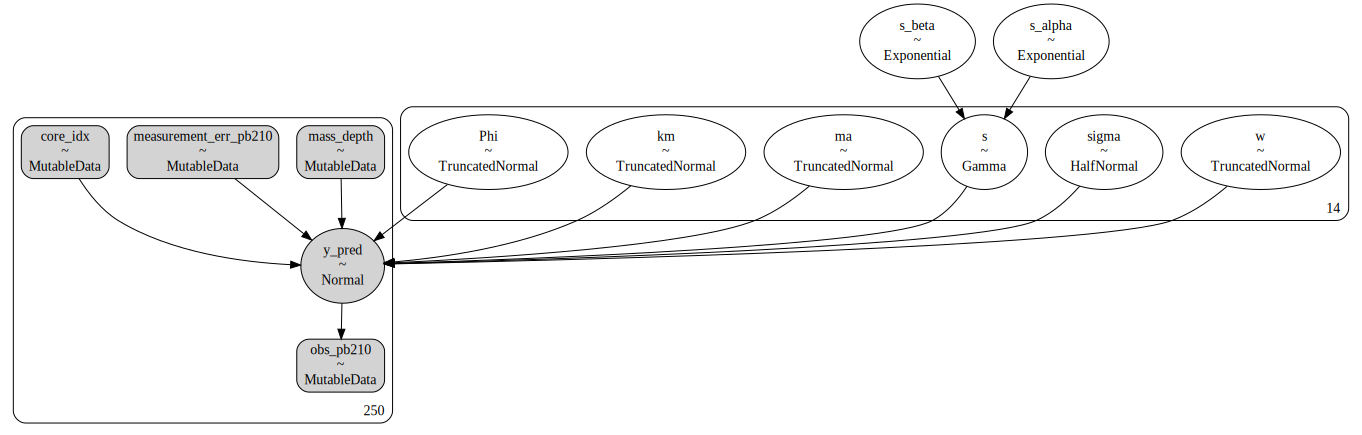

In [273]:
pm.model_to_graphviz(model)

In [274]:
with model:
    prior = pm.sample_prior_predictive(50)

In [275]:
params = ['w','Phi','ma', 'km', 's']
prior_df = pd.DataFrame()
for param in params:
    prior_df[param] = prior.prior[param].values.flatten()
prior_df;

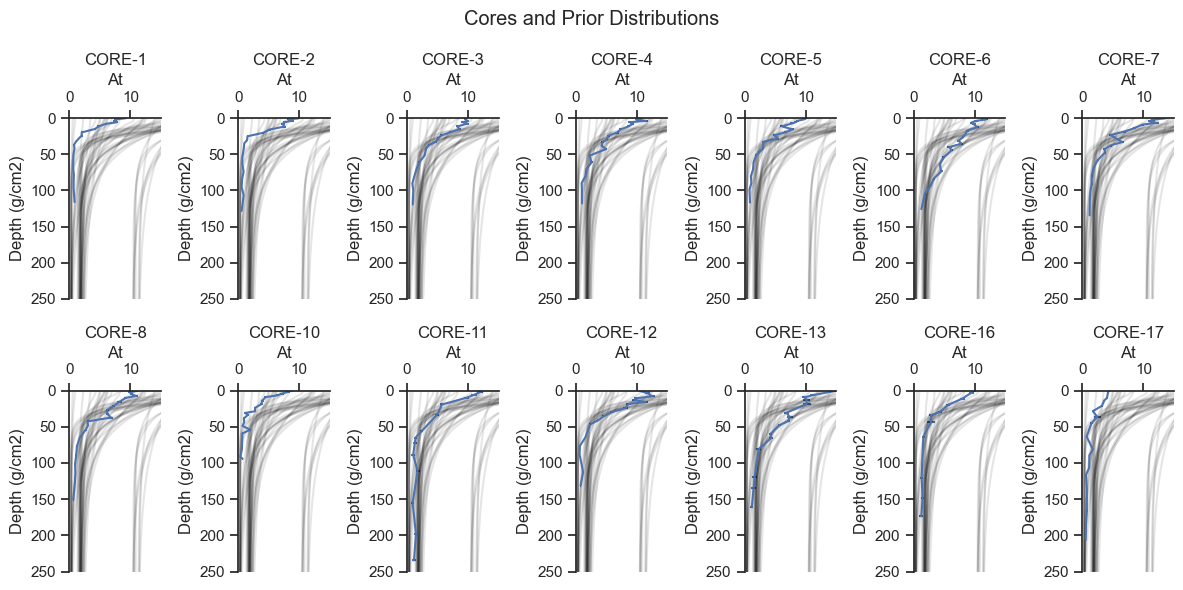

In [276]:
model_line_kwargs_list = [dict(prior_df.loc[i]) for i in range(50)]
plot_cores_w_model(cores, rows=2, cols=7, ylim = (250, 0), xlim = (0,15), figsize=(12, 6),
                 model_line_kwargs_list=model_line_kwargs_list, alpha=.1)
plt.suptitle('Cores and Prior Distributions')
plt.tight_layout()

In [277]:
pp_df = pd.DataFrame(prior.prior_predictive.y_pred.values[0].T)
pp_df
pp_df['Core'] = fit_data.Core.values
pp_df['Median_mass_g_cm2'] = fit_data.Median_mass_g_cm2.values
pp_df.head();

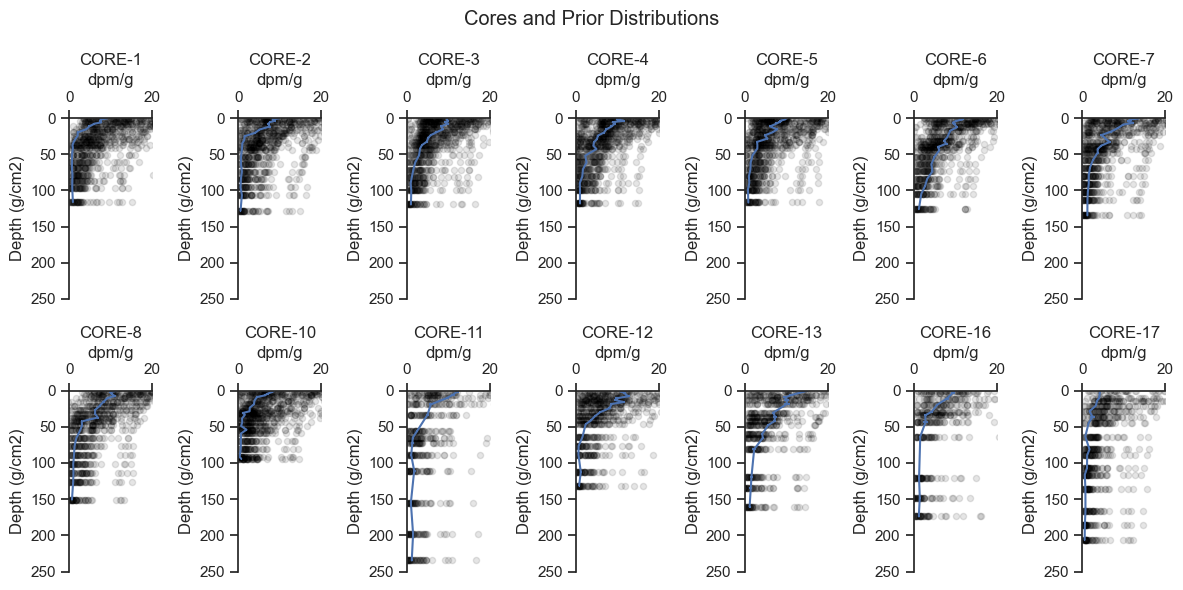

In [278]:
plot_cores_w_predictive(cores, rows=2, cols=7, ylim = (250, 0), xlim = (0,20), figsize=(12, 6))
plt.suptitle('Cores and Prior Distributions')
plt.tight_layout()

### Sample and Evaluate Posterior

In [280]:
with model:
    trace = pm.sample(target_accept=.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, Phi, ma, km, s_alpha, s_beta, s, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 937 seconds.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8734, but should be close to 0.95. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8901, but should be close to 0.95. Try to increase the number of tuning steps.


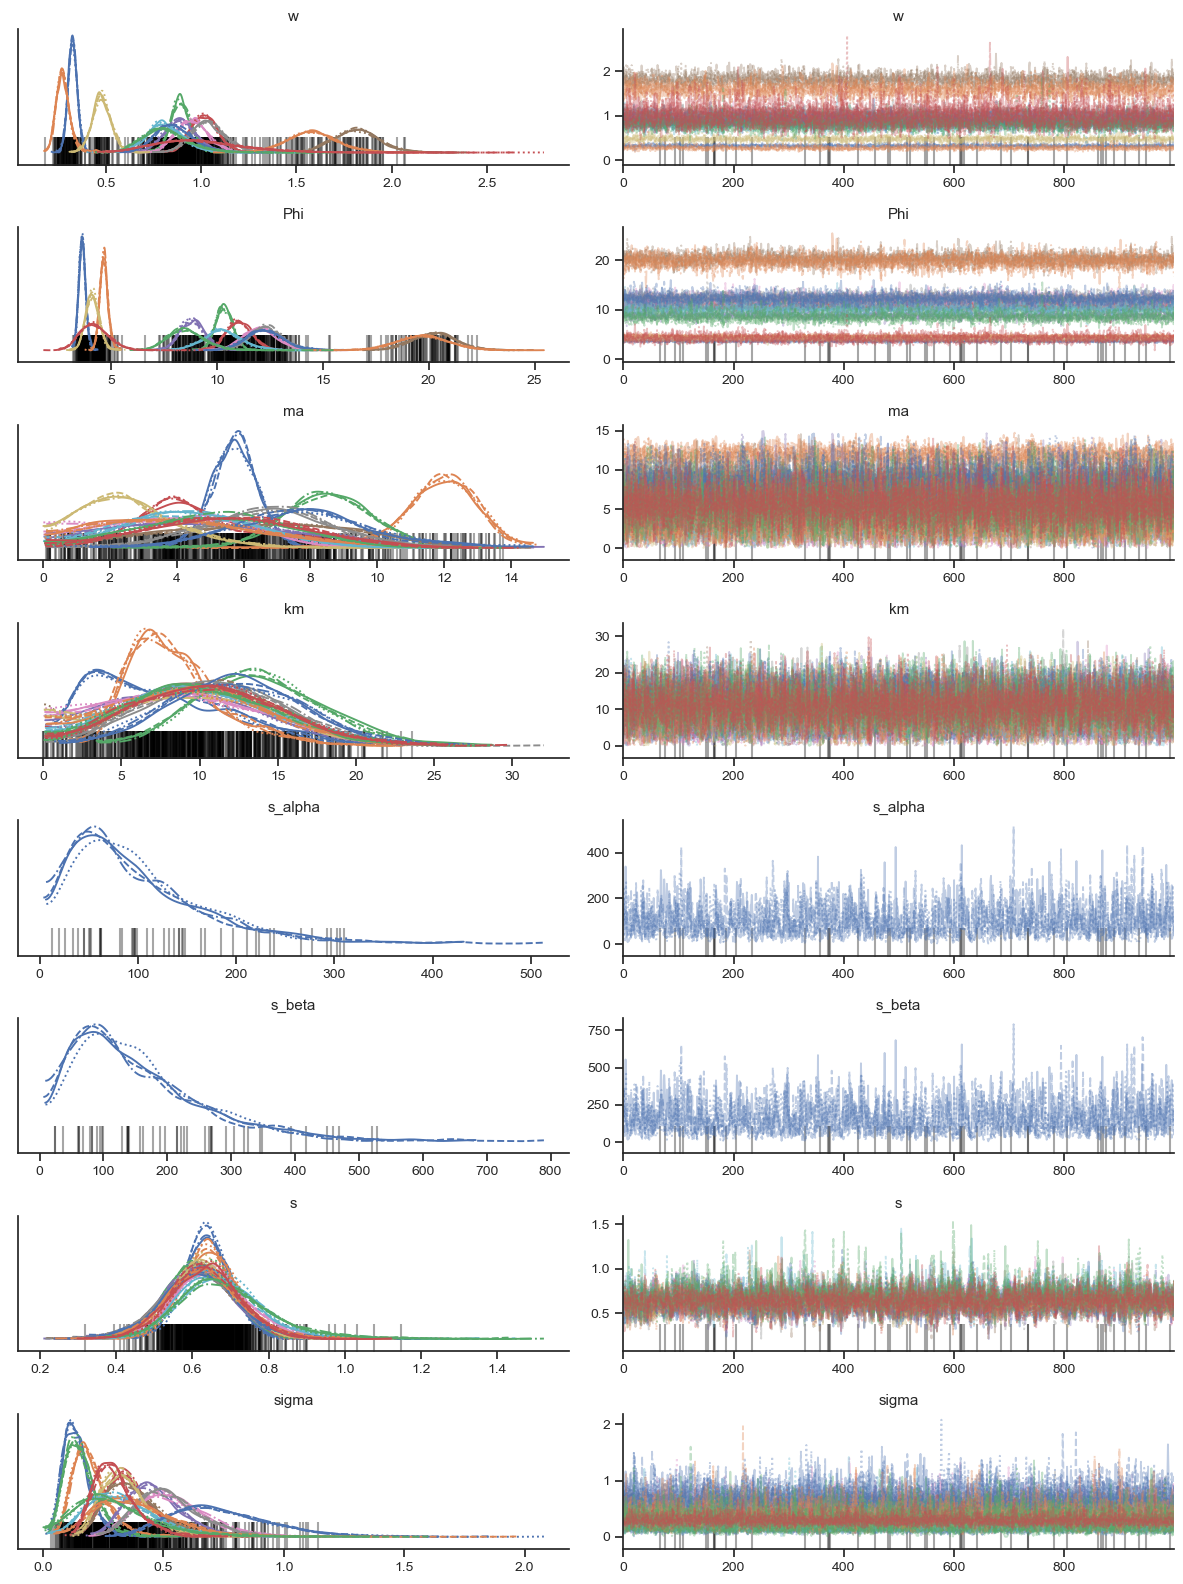

In [281]:
az.plot_trace(trace)
sns.despine()
plt.tight_layout()

In [282]:
summary = az.summary(trace)
summary[summary.r_hat > 1.00]

Empty DataFrame
Columns: [mean, sd, hdi_3%, hdi_97%, mcse_mean, mcse_sd, ess_bulk, ess_tail, r_hat]
Index: []

### Share Parameter S

In [283]:
def analytical_model_one_s(w, Phi, ma, km, s, core_idx, mass_depth):
    
    # analytical model equations - written to accept pymc variables
    xp = (w[core_idx] + (w[core_idx]**2 + 4 * lam * km[core_idx])**(1/2))/(2 * km[core_idx])
    xm = (w[core_idx] - (w[core_idx]**2 + 4 * lam * km[core_idx])**(1/2))/(2 * km[core_idx])
    eps = xm / xp * pm.math.exp((xm-xp)*ma[core_idx])
    Gamp = w[core_idx] - km[core_idx] * xp
    Gamm = w[core_idx] - km[core_idx] * xm
    Cm = Phi[core_idx] / (Gamm - eps * Gamp)
    Cp = - eps * Cm
    CII = (pm.math.exp(xm * ma[core_idx]) - eps * pm.math.exp(xp * ma[core_idx]) 
            ) * Cm / pm.math.exp(-lam  * ma[core_idx] / w[core_idx])
    
    # Ct is the prediction 
    # select correct equation on either side of ma
    Ct = pm.math.switch(ma[core_idx] > mass_depth,
        Cp  * pm.math.exp(xp * mass_depth) + Cm * pm.math.exp(xm * mass_depth) + s,
        CII * pm.math.exp(-lam * mass_depth / w[core_idx]) + s)
    return Ct


In [285]:

model = pm.Model()
with model:
    # data
    core_idx = pm.MutableData('core_idx', fit_data.Core_idx.values)
    mass_depth = pm.MutableData('mass_depth', fit_data.Median_mass_g_cm2.values )
    obs_pb210 = pm.MutableData('obs_pb210', fit_data.Pb210.values )
    measurement_err_pb210 = pm.MutableData('measurement_err_pb210', fit_data.Pb210_Err.values )

    # Priors for unknown model parameters
    w = pm.TruncatedNormal('w', mu = w_prior, sigma = w_prior,  lower=0.05, shape=no_cores)   # g/cm2/yr
    Phi = pm.TruncatedNormal('Phi', mu = Phi_prior, sigma = Phi_prior, lower=0.1,  shape=no_cores)     # dpm/cm2/yr
    ma = pm.TruncatedNormal('ma', mu = ma_prior, sigma = ma_prior/2, lower=0, upper=15, shape=no_cores) 
    km = pm.TruncatedNormal('km', mu = km_prior, sigma = km_prior/2, lower=0, shape=no_cores)         # g2/cm4/yr
    s = pm.Gamma('s', mu = s_prior, sigma=s_prior)

    Ct = analytical_model_one_s(w, Phi, ma, km, s, core_idx, mass_depth)
  
    # sampling error - added to measurement error for each core
    sigma = pm.HalfNormal('sigma', sigma=1, shape=no_cores)  
    
    # Likelihood (sampling distribution) of observations
    y_pred = pm.Normal('y_pred', mu=Ct, sigma=measurement_err_pb210 + sigma[core_idx],  observed=obs_pb210)

In [286]:
model

     w ~ TruncatedNormal(1, 1, 0.05, inf)
   Phi ~ TruncatedNormal(10, 10, 0.1, inf)
    ma ~ TruncatedNormal(5, 2.5, 0, 15)
    km ~ TruncatedNormal(10, 5, 0, inf)
     s ~ Gamma(1, f())
 sigma ~ N**+(0, 1)
y_pred ~ N(f(ma, s, Phi, w, km), f(sigma))

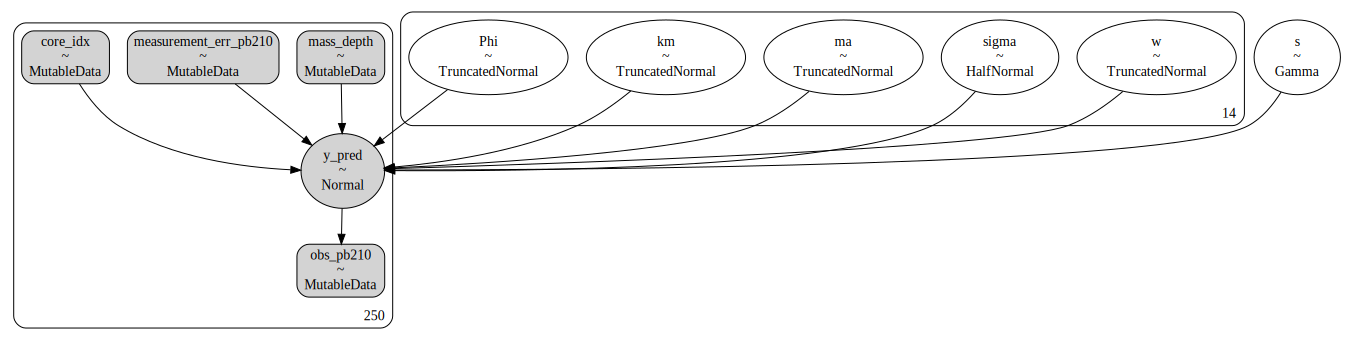

In [287]:
pm.model_to_graphviz(model)

In [288]:
with model:
    prior = pm.sample_prior_predictive(50)

In [294]:
params = ['w','Phi','ma', 'km', 's']
prior_df = pd.DataFrame()
for param in params:
    values = prior.prior[param].values.flatten()
    if param == 's':
        values = list(values)*14
    prior_df[param] = values
prior_df;

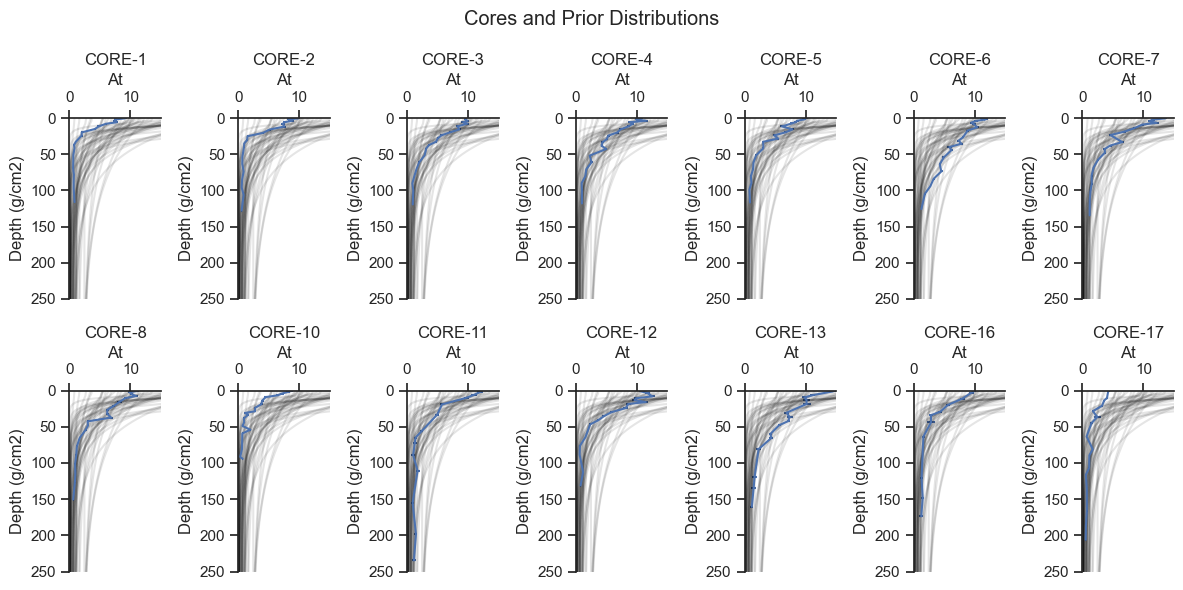

In [295]:
model_line_kwargs_list = [dict(prior_df.loc[i]) for i in range(50)]
plot_cores_w_model(cores, rows=2, cols=7, ylim = (250, 0), xlim = (0,15), figsize=(12, 6),
                 model_line_kwargs_list=model_line_kwargs_list, alpha=.1)
plt.suptitle('Cores and Prior Distributions')
plt.tight_layout()

In [296]:
pp_df = pd.DataFrame(prior.prior_predictive.y_pred.values[0].T)
pp_df
pp_df['Core'] = fit_data.Core.values
pp_df['Median_mass_g_cm2'] = fit_data.Median_mass_g_cm2.values
pp_df.head();

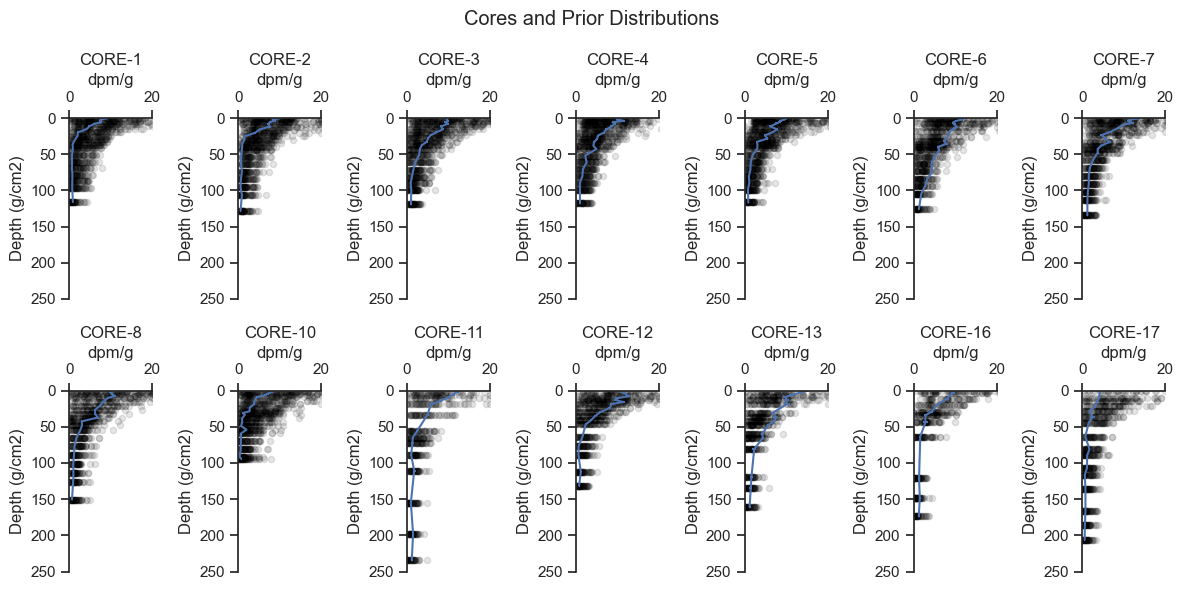

In [297]:
plot_cores_w_predictive(cores, rows=2, cols=7, ylim = (250, 0), xlim = (0,20), figsize=(12, 6))
plt.suptitle('Cores and Prior Distributions')
plt.tight_layout()

### Sample and Evaluate Posterior

In [298]:
with model:
    trace = pm.sample(target_accept=.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, Phi, ma, km, s, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 189 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


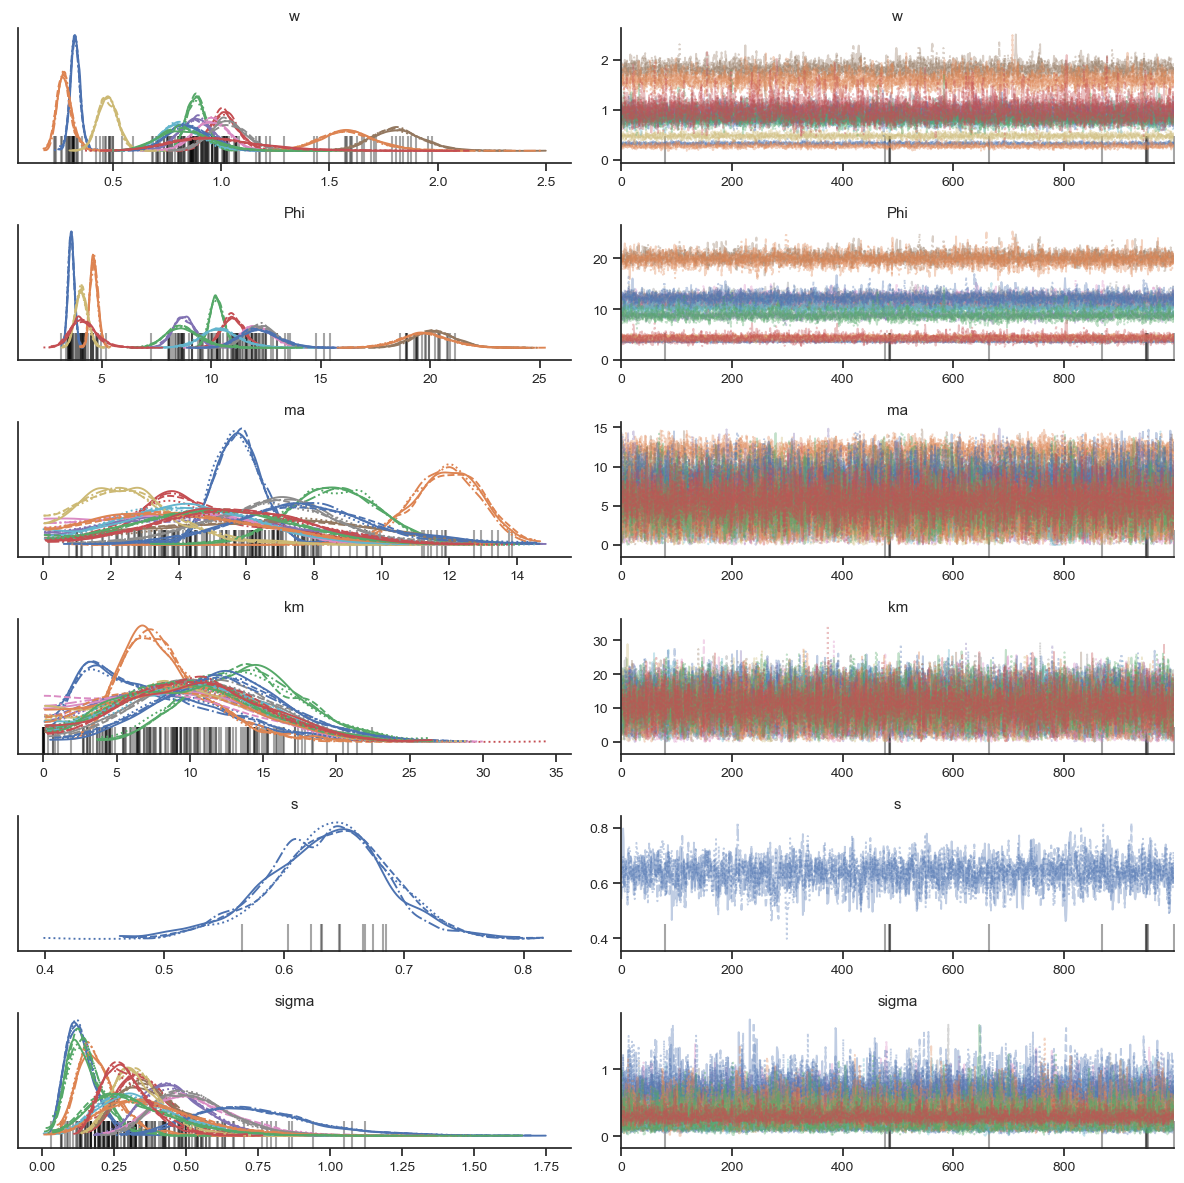

In [299]:
az.plot_trace(trace)
sns.despine()
plt.tight_layout()

In [301]:
summary = az.summary(trace)
summary[summary.r_hat > 1.00]

Empty DataFrame
Columns: [mean, sd, hdi_3%, hdi_97%, mcse_mean, mcse_sd, ess_bulk, ess_tail, r_hat]
Index: []